# Latar Belakang

New York City Taxi and Limousine Commission (NYC TLC) merupakan lembaga pemerintah kota yang bertanggung jawab dalam mengatur dan mengawasi layanan penyewaan transportasi, termasuk taksi kuning dan kendaraan sewaan di New York City. Sebagai regulator, TLC memiliki peran penting dalam menjaga kualitas layanan, keamanan penumpang, serta efisiensi operasional sistem transportasi publik berbasis kendaraan.

Taksi di New York City sendiri merupakan salah satu sarana transportasi vital, khususnya di area dengan aktivitas tinggi seperti Manhattan, Brooklyn, dan kawasan bandara. Setiap zona di kota ini menunjukkan pola mobilitas yang unik, baik dari segi intensitas penggunaan taksi, jarak perjalanan, durasi tempuh, hingga pendapatan yang dihasilkan dari tiap perjalanan. Memahami dinamika ini sangat penting bagi operator layanan transportasi maupun pembuat kebijakan, guna mengoptimalkan penempatan armada, efisiensi operasional, dan peningkatan kualitas layanan.

Namun, seringkali terjadi ketidakseimbangan antara ketersediaan taksi dengan permintaan penumpang di berbagai zona. Di satu sisi, ada zona yang kelebihan pasokan taksi namun minim permintaan. Di sisi lain, terdapat titik-titik yang mengalami kekurangan layanan saat permintaan sedang tinggi. Ketimpangan ini dapat mengakibatkan potensi pendapatan yang tidak maksimal dan waktu tunggu yang lama bagi penumpang.

Oleh karena itu, saya sebagai bagian dari tim Strategic Planning dari NYC TLC perlu melakukan analisis mendalam terhadap data perjalanan taksi yang bersifat spasial dan temporal. Tujuannya adalah untuk mengidentifikasi pola-pola mobilitas, menilai distribusi permintaan dan pasokan layanan, serta menyusun strategi operasional yang lebih responsif terhadap kebutuhan riil di lapangan, sejalan dengan misi NYC TLC dalam menyediakan transportasi yang kompeten, aman, dan terjangkau bagi seluruh warga kota, sekaligus memberi efek keuntungan secara finansial kepada vendor-vendor yang terlibat.

Sebagai acuan, studi yang dilakukan oleh Yang Liu dan Samitha Samaranayake yang berjudul `"Proactive rebalancing and speed-up techniques for on-demand high capacity ridesourcing services"` mengklaim bahwa relokasi armada taksi di New York mampu meningkatkan layanan sebesar 4.8%, dengan rata-rata penurunan waktu tunggu penumpang sebesar 5% dan delay total 10.7%. 

(Sumber: [arxiv.org/abs/1902.03374](https://arxiv.org/abs/1902.03374))

# Rumusan Masalah

- **Zona lokasi (pickup dan dropoff) dan rute perjalanan mana yang memiliki aktivitas perjalanan tertinggi dan berkontribusi terhadap revenue selama Januari 2023?**

- **Apakah ada hari dan waktu tertentu di mana terdapat kenaikan atau penurunan aktivitas dan revenue?**

- **Apa rekomendasi alokasi armada dan kebijakan operasional berdasarkan pola rute dan waktu?**



# Tujuan

Menyediakan insight strategis berbasis lokasi dan rute perjalanan taksi, untuk membantu stakeholder (tim operasional dari para Vendor) dalam mengambil keputusan alokasi operasional, perencanaan tarif dinamis, dan optimalisasi layanan.

# Data

In [203]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import plotly.express as px
import nbformat
from scipy.stats import chi2_contingency

pd.set_option('display.max_columns', None)
import warnings

warnings.filterwarnings("ignore")

In [204]:
df_nyc = pd.read_csv('NYC TLC Trip Record.csv') #dataset utama
df_nyc.sample(5)

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge
41004,2,2023-01-21 09:04:09,2023-01-21 09:13:45,N,1.0,130,130,1.0,1.51,10.70,0.0,0.5,0.0,0.0,NaN,1.0,12.20,2.0,1.0,0.00
40108,2,2023-01-20 18:13:51,2023-01-20 18:26:32,N,1.0,82,70,2.0,2.84,16.30,2.5,0.5,0.0,0.0,NaN,1.0,20.30,2.0,1.0,0.00
25443,2,2023-01-13 16:43:56,2023-01-13 16:55:06,N,1.0,43,237,5.0,2.10,12.80,2.5,0.5,0.0,0.0,NaN,1.0,19.55,2.0,1.0,2.75
64308,2,2023-01-04 07:54:00,2023-01-04 08:10:00,NaN,NaN,41,239,NaN,2.19,17.59,0.0,0.0,6.4,0.0,NaN,1.0,27.74,NaN,NaN,NaN
47413,1,2023-01-24 13:52:37,2023-01-24 13:52:46,N,1.0,220,220,1.0,0.00,15.20,0.0,1.5,0.0,0.0,NaN,1.0,16.70,1.0,1.0,0.00


In [205]:
df_loc = pd.read_csv('NYC TLC Location.csv') #dataset pendukung
df_loc.sample(5)

,LocationID,Borough,Zone,service_zone
251,252,Queens,Whitestone,Boro Zone
89,90,Manhattan,Flatiron,Yellow Zone
199,200,Bronx,Riverdale/North Riverdale/Fieldston,Boro Zone
65,66,Brooklyn,DUMBO/Vinegar Hill,Boro Zone
41,42,Manhattan,Central Harlem North,Boro Zone


## Merge Dataset

Dataset utama dan pendukung di-merge agar mendapat nama-nama yang berhubungan dengan lokasi

In [206]:
df = df_nyc.merge(df_loc[['LocationID', 'Borough', 'Zone', 'service_zone']], 
                  left_on='PULocationID', 
                  right_on='LocationID', 
                  how='left')

df = df.rename(columns={
    'Borough': 'PU_Borough',
    'Zone': 'PU_Zone',
    'service_zone': 'PUService_Zone'})

df = df.drop('LocationID', axis=1)

In [207]:
df = df.merge(df_loc[['LocationID', 'Borough', 'Zone', 'service_zone']], 
              left_on='DOLocationID', 
              right_on='LocationID', 
              how='left')

df = df.rename(columns={
    'Borough': 'DO_Borough',
    'Zone': 'DO_Zone',
    'service_zone': 'DOService_Zone'})

df = df.drop('LocationID', axis=1)

In [208]:
df.sample(5, random_state=14)

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge,PU_Borough,PU_Zone,PUService_Zone,DO_Borough,DO_Zone,DOService_Zone
10886,2,2023-01-06 17:10:21,2023-01-06 17:25:13,N,1.0,74,43,1.0,2.18,15.6,2.5,0.5,3.35,0.00,NaN,1.0,25.70,1.0,1.0,2.75,Manhattan,East Harlem North,Boro Zone,Manhattan,Central Park,Yellow Zone
52486,2,2023-01-26 14:07:31,2023-01-26 14:23:48,N,1.0,152,75,1.0,2.97,17.7,0.0,0.5,5.76,0.00,NaN,1.0,24.96,1.0,1.0,0.00,Manhattan,Manhattanville,Boro Zone,Manhattan,East Harlem South,Boro Zone
4296,2,2023-01-03 18:46:09,2023-01-03 18:56:41,N,1.0,43,262,1.0,1.55,11.4,2.5,0.5,3.63,0.00,NaN,1.0,21.78,1.0,1.0,2.75,Manhattan,Central Park,Yellow Zone,Manhattan,Yorkville East,Yellow Zone
4103,2,2023-01-03 16:51:13,2023-01-03 17:14:08,N,5.0,150,201,1.0,8.61,40.0,0.0,0.0,1.88,2.45,NaN,1.0,45.33,1.0,2.0,0.00,Brooklyn,Manhattan Beach,Boro Zone,Queens,Rockaway Park,Boro Zone
38958,2,2023-01-20 11:36:21,2023-01-20 11:47:14,N,1.0,74,43,1.0,1.45,11.4,0.0,0.5,3.00,0.00,NaN,1.0,15.90,1.0,1.0,0.00,Manhattan,East Harlem North,Boro Zone,Manhattan,Central Park,Yellow Zone


## Deskripsi Data

Analisis ini menggunakan dataset **NYC TLC Trip Record** yang sudah di-merge dengan dataset yang berisi keterangan lokasi. 

Data-data ini berisi keterangan perjalanan selama periode bulan Januari 2023.

Penjelasan tiap kolom setelah merge adalah sebagai berikut:

- **VendorID**  
  Kode yang menunjukkan perusahaan penyedia layanan taksi.  
  `1 = Creative Mobile Technologies`, `2 = VeriFone Inc.`

- **lpep_pickup_datetime**  
  Tanggal dan waktu ketika argo mulai berjalan (penumpang naik).

- **lpep_dropoff_datetime**  
  Tanggal dan waktu ketika argo berhenti (penumpang turun).

- **passenger_count**  
  Jumlah penumpang dalam kendaraan. Nilai ini dimasukkan oleh pengemudi.

- **trip_distance**  
  Jarak tempuh perjalanan dalam mil, berdasarkan data dari argo.

- **PULocationID**  
  ID zona lokasi penjemputan (pickup) berdasarkan wilayah taksi TLC.

- **DOLocationID**  
  ID zona lokasi pengantaran (dropoff) berdasarkan wilayah taksi TLC.

- **RateCodeID**  
  Kode tarif yang digunakan pada akhir perjalanan:  
  `1 = Standard rate`, `2 =JFK`, `3 =Newark`, `4 =Nassau or Westchester`, `5 =Negotiated fare`, `6 =Group ride`

- **store_and_fwd_flag**  
  Menunjukkan apakah data perjalanan sempat disimpan di memori kendaraan sebelum dikirim:  
  `Y = store and forward trip`, `N = not a store and forward trip`
- **payment_type**  
  Kode jenis pembayaran yang digunakan oleh penumpang:  
 `1 = Credit card`, `2 = Cash`, `3 = No charge`, `4 = Dispute`, `5 = Unknown`, `6 = Voided trip`

- **fare_amount**  
  Biaya perjalanan berdasarkan waktu dan jarak yang dihitung argo (belum termasuk biaya tambahan).

- **extra**  
  Biaya tambahan lainnya, seperti biaya jam sibuk ($0.50) dan malam hari ($1).

- **mta_tax**  
  Pajak MTA sebesar $0.50 yang dikenakan secara otomatis.

- **improvement_surcharge**  
  Biaya tambahan $0.30 yang dikenakan untuk meningkatkan layanan taksi, mulai diterapkan sejak 2015.

- **tip_amount**  
  Jumlah tip yang diberikan, otomatis tercatat untuk pembayaran dengan kartu kredit (tidak mencakup tip tunai).

- **tolls_amount**  
  Total biaya tol yang dibayarkan selama perjalanan.

- **total_amount**  
  Jumlah total yang dibebankan ke penumpang, tidak termasuk tip tunai.

- **trip_type**  
  Jenis perjalanan berdasarkan cara penumpang memesan taksi:  
  `1 = Street-hail`, `2 = Dispatch`

- **congestion_surcharge**  
  Jumlah tambahan pembayaran karena kemacetan

- **PU_Borough**  
  Nama wilayah penjemputan

- **PU_Zone**  
  Nama komplek penjemputan

- **PUService_Zone**  
  Wilayah jasa penjemputan

- **DO_Borough**  
  Nama wilayah pengantaran

- **DO_Zone**  
  Nama komplek pengantaran

- **DOService_Zone**  
  Wilayah jasa pengantaran

In [209]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68211 entries, 0 to 68210
Data columns (total 26 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   VendorID               68211 non-null  int64  
 1   lpep_pickup_datetime   68211 non-null  object 
 2   lpep_dropoff_datetime  68211 non-null  object 
 3   store_and_fwd_flag     63887 non-null  object 
 4   RatecodeID             63887 non-null  float64
 5   PULocationID           68211 non-null  int64  
 6   DOLocationID           68211 non-null  int64  
 7   passenger_count        63887 non-null  float64
 8   trip_distance          68211 non-null  float64
 9   fare_amount            68211 non-null  float64
 10  extra                  68211 non-null  float64
 11  mta_tax                68211 non-null  float64
 12  tip_amount             68211 non-null  float64
 13  tolls_amount           68211 non-null  float64
 14  ehail_fee              0 non-null      float64
 15  im

# Data Cleaning/Wrangling

## Data Null

In [210]:
null_percentage = (df.isnull().sum() / len(df)) * 100

null_info = pd.DataFrame({'Jumlah Null': df.isnull().sum(),
                          'Persentase Null': (df.isnull().sum() / len(df) * 100).map('{:.2f}%'.format)})
null_info

,Jumlah Null,Persentase Null
VendorID,0,0.00%
lpep_pickup_datetime,0,0.00%
lpep_dropoff_datetime,0,0.00%
store_and_fwd_flag,4324,6.34%
RatecodeID,4324,6.34%
PULocationID,0,0.00%
DOLocationID,0,0.00%
passenger_count,4324,6.34%
trip_distance,0,0.00%
fare_amount,0,0.00%


Kolom-kolom yang memiliki nilai null dapat dikelompokkan menjadi 3 berdasarkan jumlah data nullnya, yaitu:
- **Full Null**: Nilai null di `ehail_fee` adalah 100%, sehingga dapat disimpulkan bahwa kolom tersebut tidak berguna
- **Low Null** : Kolom `store_and_fwd_flag`, `RatecodeID`, `passenger_count`, `payment_type`, `trip_type`, `congestion_surcharge` memiliki persentase nilai null sekitar 6,3%, di mana akan di-handling menggunakan pendekatan sesuai dari value kolomnya
- **Very Low Null**: Kolom `PU_Zone`, `PUService_Zone`, `DO_Zone`, dan `DOService_Zone` memiliki persemtase nilai null yang sangat kecil, yaitu <1%

In [211]:
null_columns = df.columns[df.isnull().any()]
null_columns

Index(['store_and_fwd_flag', 'RatecodeID', 'passenger_count', 'ehail_fee',
       'payment_type', 'trip_type', 'congestion_surcharge', 'PU_Zone',
       'PUService_Zone', 'DO_Zone', 'DOService_Zone'],
      dtype='object')

### Full Null

Drop kolom `ehail_fee` karena 100% kosong, sehingga tidak berguna untuk analisis

In [212]:
df = df.drop('ehail_fee', axis=1)

### Low Null

In [213]:
df['store_and_fwd_flag'].value_counts()

store_and_fwd_flag
N    63579
Y      308
Name: count, dtype: int64

In [214]:
df['RatecodeID'].value_counts()

RatecodeID
1.0     62103
5.0      1529
2.0       158
4.0        57
3.0        30
99.0       10
Name: count, dtype: int64

In [215]:
df['passenger_count'].value_counts()

passenger_count
1.0    54299
2.0     5096
5.0     1772
6.0     1054
3.0      958
4.0      364
0.0      336
7.0        4
9.0        2
8.0        2
Name: count, dtype: int64

In [216]:
df['payment_type'].value_counts()

payment_type
1.0    40686
2.0    22632
3.0      472
4.0       95
5.0        2
Name: count, dtype: int64

In [217]:
df['trip_type'].value_counts()

trip_type
1.0    62476
2.0     1401
Name: count, dtype: int64

In [218]:
df['congestion_surcharge'].value_counts()

congestion_surcharge
 0.00    46996
 2.75    16872
 2.50       16
-2.75        3
Name: count, dtype: int64

In [219]:
display(df[df['store_and_fwd_flag'].isna()]['trip_type'].value_counts(),
df[df['store_and_fwd_flag'].isna()]['payment_type'].value_counts(),
df[df['store_and_fwd_flag'].isna()]['RatecodeID'].value_counts(),
df[df['store_and_fwd_flag'].isna()]['passenger_count'].value_counts(),
df[df['store_and_fwd_flag'].isna()]['congestion_surcharge'].value_counts())

Series([], Name: count, dtype: int64)

Series([], Name: count, dtype: int64)

Series([], Name: count, dtype: int64)

Series([], Name: count, dtype: int64)

Series([], Name: count, dtype: int64)

In [220]:
# pd.set_option('display.max_rows', None)
df[df['store_and_fwd_flag'].isna()]

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge,PU_Borough,PU_Zone,PUService_Zone,DO_Borough,DO_Zone,DOService_Zone
63887,2,2023-01-01 00:28:00,2023-01-01 00:54:00,NaN,NaN,7,17,NaN,9.33,36.03,0.0,0.0,7.41,0.0,1.0,44.44,NaN,NaN,NaN,Queens,Astoria,Boro Zone,Brooklyn,Bedford,Boro Zone
63888,2,2023-01-01 00:39:00,2023-01-01 00:52:00,NaN,NaN,37,37,NaN,2.67,14.55,0.0,0.0,3.11,0.0,1.0,18.66,NaN,NaN,NaN,Brooklyn,Bushwick South,Boro Zone,Brooklyn,Bushwick South,Boro Zone
63889,2,2023-01-01 00:58:00,2023-01-01 01:21:00,NaN,NaN,80,7,NaN,7.39,32.13,0.0,0.0,6.63,0.0,1.0,39.76,NaN,NaN,NaN,Brooklyn,East Williamsburg,Boro Zone,Queens,Astoria,Boro Zone
63890,2,2023-01-01 00:35:00,2023-01-01 00:55:00,NaN,NaN,169,42,NaN,4.04,17.85,0.0,0.0,0.00,0.0,1.0,18.85,NaN,NaN,NaN,Bronx,Mount Hope,Boro Zone,Manhattan,Central Harlem North,Boro Zone
63891,2,2023-01-01 00:45:00,2023-01-01 00:55:00,NaN,NaN,42,262,NaN,3.86,19.67,0.0,0.0,4.68,0.0,1.0,28.10,NaN,NaN,NaN,Manhattan,Central Harlem North,Boro Zone,Manhattan,Yorkville East,Yellow Zone
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68206,2,2023-01-31 22:29:00,2023-01-31 22:42:00,NaN,NaN,49,62,NaN,4070.82,15.70,0.0,0.0,0.00,0.0,1.0,16.70,NaN,NaN,NaN,Brooklyn,Clinton Hill,Boro Zone,Brooklyn,Crown Heights South,Boro Zone
68207,2,2023-01-31 22:40:00,2023-01-31 22:48:00,NaN,NaN,10,205,NaN,2.14,4.41,0.0,0.0,0.00,0.0,1.0,5.41,NaN,NaN,NaN,Queens,Baisley Park,Boro Zone,Queens,Saint Albans,Boro Zone
68208,2,2023-01-31 23:46:00,2023-02-01 00:02:00,NaN,NaN,66,37,NaN,3.44,16.53,0.0,0.0,3.51,0.0,1.0,21.04,NaN,NaN,NaN,Brooklyn,DUMBO/Vinegar Hill,Boro Zone,Brooklyn,Bushwick South,Boro Zone
68209,2,2023-01-31 23:01:00,2023-01-31 23:19:00,NaN,NaN,225,189,NaN,3.03,14.98,0.0,0.0,3.20,0.0,1.0,19.18,NaN,NaN,NaN,Brooklyn,Stuyvesant Heights,Boro Zone,Brooklyn,Prospect Heights,Boro Zone


In [221]:
df.iloc[63710:63716] #melihat perbatasan nilai null

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge,PU_Borough,PU_Zone,PUService_Zone,DO_Borough,DO_Zone,DOService_Zone
63710,2,2023-01-31 21:46:47,2023-01-31 21:54:24,N,1.0,43,166,1.0,1.69,10.7,1.0,0.5,0.00,0.0,1.0,13.20,2.0,1.0,0.00,Manhattan,Central Park,Yellow Zone,Manhattan,Morningside Heights,Boro Zone
63711,2,2023-01-31 21:36:39,2023-01-31 21:40:08,N,5.0,7,7,1.0,0.42,7.0,0.0,0.0,0.00,0.0,0.3,7.30,1.0,2.0,0.00,Queens,Astoria,Boro Zone,Queens,Astoria,Boro Zone
63712,2,2023-01-31 21:01:52,2023-01-31 21:07:51,N,1.0,83,83,1.0,0.78,7.9,1.0,0.5,2.08,0.0,1.0,12.48,1.0,1.0,0.00,Queens,Elmhurst/Maspeth,Boro Zone,Queens,Elmhurst/Maspeth,Boro Zone
63713,2,2023-01-31 21:18:01,2023-01-31 21:27:00,N,1.0,260,7,1.0,2.43,13.5,1.0,0.5,3.20,0.0,1.0,19.20,1.0,1.0,0.00,Queens,Woodside,Boro Zone,Queens,Astoria,Boro Zone
63714,2,2023-01-31 21:25:29,2023-01-31 21:37:34,N,1.0,92,73,1.0,2.22,13.5,1.0,0.5,3.20,0.0,1.0,19.20,1.0,1.0,0.00,Queens,Flushing,Boro Zone,Queens,East Flushing,Boro Zone
63715,2,2023-01-31 21:44:43,2023-01-31 22:07:16,N,1.0,166,164,4.0,5.18,26.1,1.0,0.5,0.00,0.0,1.0,31.35,2.0,1.0,2.75,Manhattan,Morningside Heights,Boro Zone,Manhattan,Midtown South,Yellow Zone


Ditemukan bahwa:

-Kolom-kolom **Low Null** memiliki nilai null pada baris-baris yang sama

-Baris-baris itu adalah 4324 baris terakhir data.

-Baris-baris yang null memiliki nilai pada kolom `lpep_pickup_datetime` dan `lpep_dropoff_datetime` yang tidak kontinu dari data sebelumnya, sehingga dapat disimpulkan merupakan data tambahan yang baru ditambahkan ke dataset dengan perbedaan format sehingga menghasilkan banyak nilai null

Baris-baris yang null tersebut akan dihapus dengan beberapa pertimbangan berikut:

**1.** Persentase nilai null masih diambang batas yang wajar untuk dihapus (6,3%).

**2.** Jumlah data yang banyak sehingga penghapusan baris null tidak berdampak sangat signifikan.

**3.** Nilai null berada di banyak kolom, sehingga data yang tersedia menjadi tidak relevan.

**4.** Nilai-nilai null berada pada kolom yang mayoritas kategorikal (yang numerikal pun memiliki unique value yang terbatas) sehingga teknik imputing menggunakan modus dan KNN berpotensi membuat data menjadi bias.

**5.** Baris-baris yang memiliki nilai null dapat diasumsikan sebagai data tambahan jika dilihat dari value pada kolom `lpep_pickup_datetime` dan `lpep_dropoff_datetime` yang ter-reset setelah mencapai baris yang memiliki nilai null sehingga penghapusan sama saja dengan mengembalikan dataset menjadi ke awal.

In [222]:
df = df.iloc[:-4324] #penghapusan baris null

In [223]:
df[df['trip_type'].isna()]

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge,PU_Borough,PU_Zone,PUService_Zone,DO_Borough,DO_Zone,DOService_Zone
1084,1,2023-01-01 19:44:13,2023-01-01 19:58:30,N,99.0,150,55,1.0,3.3,18.2,0.0,1.5,0.0,0.0,1.0,19.7,1.0,NaN,0.0,Brooklyn,Manhattan Beach,Boro Zone,Brooklyn,Coney Island,Boro Zone
2174,1,2023-01-02 16:39:05,2023-01-02 17:31:42,N,99.0,73,82,1.0,3.7,23.5,0.0,1.5,0.0,0.0,1.0,25.0,1.0,NaN,0.0,Queens,East Flushing,Boro Zone,Queens,Elmhurst,Boro Zone
9055,1,2023-01-05 20:33:45,2023-01-05 22:46:41,N,99.0,14,123,1.0,6.2,28.2,0.0,1.5,0.0,0.0,1.0,29.7,1.0,NaN,0.0,Brooklyn,Bay Ridge,Boro Zone,Brooklyn,Homecrest,Boro Zone
14125,1,2023-01-08 11:36:41,2023-01-08 12:14:59,N,99.0,61,77,1.0,2.7,22.5,0.0,1.5,0.0,0.0,1.0,24.0,1.0,NaN,0.0,Brooklyn,Crown Heights North,Boro Zone,Brooklyn,East New York/Pennsylvania Avenue,Boro Zone
29143,1,2023-01-15 13:51:42,2023-01-15 14:37:38,N,99.0,108,181,1.0,6.5,24.2,0.0,1.5,0.0,0.0,1.0,25.7,1.0,NaN,0.0,Brooklyn,Gravesend,Boro Zone,Brooklyn,Park Slope,Boro Zone
29711,1,2023-01-15 17:52:52,2023-01-15 22:11:55,N,99.0,150,123,1.0,1.6,15.2,0.0,1.5,0.0,0.0,1.0,16.7,1.0,NaN,0.0,Brooklyn,Manhattan Beach,Boro Zone,Brooklyn,Homecrest,Boro Zone
35975,1,2023-01-19 01:07:59,2023-01-19 01:17:19,N,99.0,90,68,1.0,0.6,15.2,0.0,1.5,0.0,0.0,1.0,16.7,1.0,NaN,0.0,Manhattan,Flatiron,Yellow Zone,Manhattan,East Chelsea,Yellow Zone
37691,1,2023-01-19 17:16:59,2023-01-19 22:29:53,N,99.0,265,123,1.0,14.6,40.2,0.0,1.5,0.0,0.0,1.0,41.7,1.0,NaN,0.0,Unknown,NaN,NaN,Brooklyn,Homecrest,Boro Zone
42432,1,2023-01-21 20:29:58,2023-01-22 02:59:25,N,99.0,150,123,1.0,1.4,15.2,0.0,1.5,0.0,0.0,1.0,16.7,1.0,NaN,0.0,Brooklyn,Manhattan Beach,Boro Zone,Brooklyn,Homecrest,Boro Zone
45204,1,2023-01-23 13:45:11,2023-01-23 23:36:42,N,99.0,244,248,1.0,28.3,50.2,0.0,1.5,0.0,0.0,1.0,51.7,1.0,NaN,0.0,Manhattan,Washington Heights South,Boro Zone,Bronx,West Farms/Bronx River,Boro Zone


Kolom `trip_type` masih memiliki 10 nilai null, di mana pada baris-baris yang masih null ini memiliki nilai yang anomali pada kolom `RatecodeID` yang seharusnya hanya memiliki nilai 1-6 namun memiliki angka 99. Sehingga baris-baris ini akan dihapus.

In [224]:
df.dropna(subset=['trip_type'], inplace=True)

### Very Low Null

In [225]:
miss_PU_Zone = df[df['PU_Zone'].isna()][['PULocationID','PU_Borough']]
miss_PU_Zone.value_counts()

PULocationID  PU_Borough
265           Unknown       65
Name: count, dtype: int64

In [226]:
miss_PUService_Zone = df[df['PUService_Zone'].isna()][['PULocationID','PU_Borough']]
miss_PUService_Zone.value_counts()

PULocationID  PU_Borough
264           Unknown       135
265           Unknown        65
Name: count, dtype: int64

In [227]:
miss_DO_Zone = df[df['DO_Zone'].isna()][['DOLocationID','DO_Borough']]
miss_DO_Zone.value_counts()

DOLocationID  DO_Borough
265           Unknown       224
Name: count, dtype: int64

In [228]:
miss_DOService_Zone = df[df['DOService_Zone'].isna()][['DOLocationID','DO_Borough']]
miss_DOService_Zone.value_counts()

DOLocationID  DO_Borough
264           Unknown       424
265           Unknown       224
Name: count, dtype: int64

In [229]:
df[df['PULocationID'].isin([264, 265])][['PULocationID', 'PU_Borough', 'PU_Zone', 'PUService_Zone']].sample(5)

,PULocationID,PU_Borough,PU_Zone,PUService_Zone
29441,265,Unknown,NaN,NaN
15368,264,Unknown,NV,NaN
21631,264,Unknown,NV,NaN
37196,264,Unknown,NV,NaN
61897,265,Unknown,NaN,NaN


In [230]:
df[df['DOLocationID'].isin([264, 265])][['DOLocationID', 'DO_Borough', 'DO_Zone', 'DOService_Zone']].sample(5)

,DOLocationID,DO_Borough,DO_Zone,DOService_Zone
37288,265,Unknown,NaN,NaN
47128,265,Unknown,NaN,NaN
17041,264,Unknown,NV,NaN
21701,264,Unknown,NV,NaN
27403,264,Unknown,NV,NaN


Ditemukan bahwa nilai null pada kolom-kolom **Very Low Null** disebabkan oleh `PULocationID` dan `DOLocationID` yang bernilai **264** dan **265** tidak diketahui nama Borough, Zone, dan Service_Zone-nya. Hal ini disebabkan LocationID **264** dan **265** memang tidak diketahui namanya pada dataset NYC TLC Location.

Berbeda dengan kolom-kolom Zone dan Service_Zone, kolom Borough dari LocationID **264** dan **265** tidak bernilai null, melainkai "Unknown". Karena kolom-kolom ini berkaitan, sehingga penanganannya dilakukan sekaligus.

In [231]:
# mengisi null dengan 'Unregistered Zone' dan 'Unregistered Service Zone'
df['PU_Zone'].fillna('Unregistered Zone', inplace=True)
df['PUService_Zone'].fillna('Unregistered Service Zone', inplace=True)
df['DO_Zone'].fillna('Unregistered Zone', inplace=True)
df['DOService_Zone'].fillna('Unregistered Service Zone', inplace=True)

# mengganti 'Unknown' dengan 'Unregistered Borough'
df['PU_Borough'].replace('Unknown', 'Unregistered Borough', inplace=True)
df['DO_Borough'].replace('Unknown', 'Unregistered Borough', inplace=True)

Mempertimbangkan baris-baris yang null pada kolom **Very Low Null** penting untuk analisis karena data tripnya cukup lengkap, maka handling yang dilakukan adalah pengisian nilai null dan penggantian nilai 'Unknown' dengan label 'Unregistered'

In [232]:
# pengecekan akhir nilai null
null_columns = df.columns[df.isnull().any()]
null_columns

Index([], dtype='object')

Semua data null telah berhasil ditangani

## Data Duplikat

### Full Duplikat

In [233]:
df.duplicated().sum()

np.int64(0)

Tidak ada data yang bersifat full duplikat

### Duplikat Sebagian

Pengecekan ini untuk melihat ada atau tidaknya data duplikat pada kolom-kolom yang dikumpulkan menjadi subset. 
Kolom-kolom yang dipakai sudah dapat mewakili nilai unik dari suatu perjalanan unique

In [234]:
df.duplicated(['lpep_pickup_datetime', 'lpep_dropoff_datetime', 'PULocationID', 'DOLocationID']).sum()

np.int64(174)

In [235]:
duplikat = df[df.duplicated(subset=['lpep_pickup_datetime','lpep_dropoff_datetime', 'PULocationID', 'DOLocationID'],
                 keep=False)].head(20)
duplikat

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge,PU_Borough,PU_Zone,PUService_Zone,DO_Borough,DO_Zone,DOService_Zone
662,2,2023-01-01 14:58:13,2023-01-01 14:58:39,N,1.0,75,74,2.0,0.17,-3.0,0.0,-0.5,0.0,0.0,-1.0,-4.5,3.0,1.0,0.0,Manhattan,East Harlem South,Boro Zone,Manhattan,East Harlem North,Boro Zone
663,2,2023-01-01 14:58:13,2023-01-01 14:58:39,N,1.0,75,74,2.0,0.17,3.0,0.0,0.5,0.0,0.0,1.0,4.5,3.0,1.0,0.0,Manhattan,East Harlem South,Boro Zone,Manhattan,East Harlem North,Boro Zone
898,2,2023-01-01 17:24:52,2023-01-01 17:25:12,N,1.0,193,193,1.0,0.00,-3.0,0.0,-0.5,0.0,0.0,-1.0,-4.5,4.0,1.0,0.0,Queens,Queensbridge/Ravenswood,Boro Zone,Queens,Queensbridge/Ravenswood,Boro Zone
899,2,2023-01-01 17:24:52,2023-01-01 17:25:12,N,1.0,193,193,1.0,0.00,3.0,0.0,0.5,0.0,0.0,1.0,4.5,4.0,1.0,0.0,Queens,Queensbridge/Ravenswood,Boro Zone,Queens,Queensbridge/Ravenswood,Boro Zone
1317,2,2023-01-02 02:05:08,2023-01-02 02:12:57,N,1.0,129,82,1.0,0.64,-8.6,-1.0,-0.5,0.0,0.0,-1.0,-11.1,3.0,1.0,0.0,Queens,Jackson Heights,Boro Zone,Queens,Elmhurst,Boro Zone
1318,2,2023-01-02 02:05:08,2023-01-02 02:12:57,N,1.0,129,82,1.0,0.64,8.6,1.0,0.5,0.0,0.0,1.0,11.1,3.0,1.0,0.0,Queens,Jackson Heights,Boro Zone,Queens,Elmhurst,Boro Zone
1686,2,2023-01-02 12:56:53,2023-01-02 13:00:10,N,1.0,75,75,1.0,0.77,-4.5,0.0,-0.5,0.0,0.0,-0.3,-5.3,4.0,1.0,0.0,Manhattan,East Harlem South,Boro Zone,Manhattan,East Harlem South,Boro Zone
1687,2,2023-01-02 12:56:53,2023-01-02 13:00:10,N,1.0,75,75,1.0,0.77,4.5,0.0,0.5,0.0,0.0,0.3,5.3,4.0,1.0,0.0,Manhattan,East Harlem South,Boro Zone,Manhattan,East Harlem South,Boro Zone
1864,2,2023-01-02 13:51:33,2023-01-02 13:52:42,N,1.0,75,75,2.0,0.08,-3.7,0.0,-0.5,0.0,0.0,-1.0,-5.2,3.0,1.0,0.0,Manhattan,East Harlem South,Boro Zone,Manhattan,East Harlem South,Boro Zone
1865,2,2023-01-02 13:51:33,2023-01-02 13:52:42,N,1.0,75,75,2.0,0.08,3.7,0.0,0.5,0.0,0.0,1.0,5.2,3.0,1.0,0.0,Manhattan,East Harlem South,Boro Zone,Manhattan,East Harlem South,Boro Zone


Dengan sampel 10 pasang data duplikat pertama berdasarkan `lpep_pickup_datetime`, `lpep_dropoff_datetime`, `PULocationID`, dan `DOLocationID`, ditemukan pola dari tiap pasangan duplikat memiliki kesamaan di waktu & lokasi baik saat penjemputan dan juga pengantaran, yang mana tidak mungkin terjadi karena waktu yang dipakai adalah waktu yang detail sampai ke detik penjemputan/pengantaran. Bahkan jika dilihat lagi pada kolom lain seperti `passenger_count`, `trip_distance`, dll. juga memiliki nilai yang sama.

Yang membedakan pasangan baris duplikat tersebut adalah pada kolom-kolom yang berkaitan dengan biaya seperti `fare_amount`, `mta_tax`, `extra`, dll. memiliki nilai minus pada salah satu barisnya sehingga tidak tergolong secara duplikat jika dicek secara menyeluruh.

Dengan melihat analisis di atas, baris-baris duplikat yang memiliki nilai minus akan dihapus

In [236]:
# untuk menandai baris-baris duplikat
df['duplikat'] = df.duplicated(subset=['lpep_pickup_datetime','lpep_dropoff_datetime', 'PULocationID', 'DOLocationID'], keep=False)

# untuk menandai baris-baris negatif
df['negatif'] = ((df['fare_amount'] < 0) | (df['extra'] < 0) | (df['mta_tax'] < 0) | (df['total_amount'] < 0) | (df['improvement_surcharge'] < 0))

# drop baris duplikat yang memiliki nilai minus
df = df[~((df['duplikat']) & (df['negatif']))]

# drop kolom negatif dan duplikat karena tidak terpakai lagi
df.drop(columns=['negatif', 'duplikat'], inplace=True)

In [237]:
df.duplicated(['lpep_pickup_datetime', 'lpep_dropoff_datetime', 'PULocationID', 'DOLocationID']).sum()

np.int64(0)

Data duplikat berhasil dihapus

## Data Anomali

Untuk kebutuhan analisis, kolom `lpep_pickup_datetime` dan `lpep_dropoff_datetime` akan diubah menjadi tipe data **datetime** 

In [238]:
df['lpep_pickup_datetime'] = pd.to_datetime(df['lpep_pickup_datetime'])
df['lpep_dropoff_datetime'] = pd.to_datetime(df['lpep_dropoff_datetime'])

In [239]:
df.sort_values('lpep_pickup_datetime')

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge,PU_Borough,PU_Zone,PUService_Zone,DO_Borough,DO_Zone,DOService_Zone
17874,2,2009-01-01 20:21:27,2009-01-02 11:07:31,N,1.0,65,178,1.0,7.72,34.5,0.0,0.5,7.20,0.00,1.0,43.20,1.0,1.0,0.00,Brooklyn,Downtown Brooklyn/MetroTech,Boro Zone,Brooklyn,Ocean Parkway South,Boro Zone
298,2,2022-12-09 14:10:49,2022-12-09 14:22:26,N,1.0,7,56,1.0,5.37,16.0,0.0,0.5,0.00,0.00,0.3,16.80,2.0,1.0,0.00,Queens,Astoria,Boro Zone,Queens,Corona,Boro Zone
318,2,2022-12-09 14:55:42,2022-12-09 15:33:06,N,1.0,260,164,1.0,5.48,25.5,0.0,0.5,0.00,6.55,0.3,35.60,2.0,1.0,2.75,Queens,Woodside,Boro Zone,Manhattan,Midtown South,Yellow Zone
24,2,2023-01-01 00:01:31,2023-01-01 00:16:02,N,1.0,166,244,1.0,2.48,16.3,1.0,0.5,3.76,0.00,1.0,22.56,1.0,1.0,0.00,Manhattan,Morningside Heights,Boro Zone,Manhattan,Washington Heights South,Boro Zone
44,2,2023-01-01 00:04:25,2023-01-01 00:17:50,N,1.0,255,146,1.0,2.80,16.3,1.0,0.5,2.80,0.00,1.0,21.60,1.0,1.0,0.00,Brooklyn,Williamsburg (North Side),Boro Zone,Queens,Long Island City/Queens Plaza,Boro Zone
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63844,1,2023-01-31 23:45:10,2023-01-31 23:54:53,N,1.0,166,244,1.0,3.20,14.9,1.0,1.5,3.45,0.00,1.0,20.85,1.0,1.0,0.00,Manhattan,Morningside Heights,Boro Zone,Manhattan,Washington Heights South,Boro Zone
63876,2,2023-01-31 23:53:41,2023-02-01 00:31:14,N,1.0,82,83,2.0,6.44,38.0,1.0,0.5,0.00,0.00,1.0,40.50,2.0,1.0,0.00,Queens,Elmhurst,Boro Zone,Queens,Elmhurst/Maspeth,Boro Zone
63858,2,2023-01-31 23:56:16,2023-02-01 00:03:16,N,1.0,95,196,1.0,1.16,8.6,1.0,0.5,2.22,0.00,1.0,13.32,1.0,1.0,0.00,Queens,Forest Hills,Boro Zone,Queens,Rego Park,Boro Zone
63872,2,2023-01-31 23:58:23,2023-02-01 00:07:16,N,1.0,95,135,1.0,1.39,10.7,1.0,0.5,2.64,0.00,1.0,15.84,1.0,1.0,0.00,Queens,Forest Hills,Boro Zone,Queens,Kew Gardens Hills,Boro Zone


Terdapat keanehan pada `lpep_pickup_datetime` dan `lpep_dropoff_datetime` di mana terdapat beberapa data yang keluar dari rentang waktu bulan Januari 2023.

Agar data lebih relevan, data dibatasi hanya pada **penjemputan** yang berada pada rentang bulan Januari 2023. Sehingga, penjemputan yang berada di luar pada rentang tersebut akan dihapus (tidak termasuk pada penjemputan 31 Januari 2023 yang menghasilkan waktu pengantaran 1 Februari 2023)

### `lpep_pickup_datetime`

In [240]:
df = df[
    (df['lpep_pickup_datetime'].dt.year == 2023) &
    (df['lpep_pickup_datetime'].dt.month == 1)
]

`lpep_pickup_datetime` berhasil dibersihkan

Untuk analisis lebih lanjut, diperlukan penambahan kolom baru yaitu `trip_duration_min` yang berisi berapa lama perjalanan dari penjemputan sampai pengantaran, `pickup_day` yang berisi nama hari pada saat penjemputan, dan `pickup_date` yang berisi hanya tanggal penjemputan, dan `pickup_hour` yang berisi jam penjemputan.

In [241]:
df['trip_duration_min'] = (df['lpep_dropoff_datetime'] - df['lpep_pickup_datetime']).dt.total_seconds() / 60
df['trip_duration_min'] = df['trip_duration_min'].round(2)

df['pickup_day'] = df['lpep_pickup_datetime'].dt.day_name()

df['pickup_date'] = df['lpep_pickup_datetime'].dt.date

df['pickup_hour'] = df['lpep_pickup_datetime'].dt.hour


Untuk mempermudah dalam analisis, kolom dengan value-value berupa kode akan diubah menjadi value aslinya agar lebih representatif

In [242]:
vendor_map = {
    1: 'Creative Mobile Technologies (CMT)',
    2: 'VeriFone Inc. (VTS)'}

ratecode_map = {
    1: 'Standard Rate',
    2: 'JFK',
    3: 'Newark',
    4: 'Nassau or Westchester',
    5: 'Negotiated Fare',
    6: 'Group Ride'}

payment_map = {
    1: 'Credit Card',
    2: 'Cash',
    3: 'No Charge',
    4: 'Dispute',
    5: 'Unknown',
    6: 'Voided Trip'}

trip_type_map = {
    1: 'Street Hail',
    2: 'Dispatch'}

In [243]:
df['VendorName'] = df['VendorID'].map(vendor_map)
df['RatecodeName'] = df['RatecodeID'].map(ratecode_map)
df['payment_method'] = df['payment_type'].map(payment_map)
df['trip_type'] = df['trip_type'].map(trip_type_map)

Kolom-kolom yang bersifat kode dihapus karena tidak dibutuhkan lagi dalam analisis

In [244]:
df.drop(['VendorID','RatecodeID','payment_type','PULocationID','DOLocationID'],axis=1,inplace=True)

Membuat sebuah kolom baru yaitu `route` yang berisi gabungan `PU_Zone` dan `DO_ZOne`

In [245]:
df['route'] = df['PU_Zone'] + " → " + df['DO_Zone']

In [246]:
# Statistic Descriptive awal
df.describe()

,lpep_pickup_datetime,lpep_dropoff_datetime,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,trip_duration_min,pickup_hour
count,63699,63699,63699.000000,63699.000000,63699.000000,63699.000000,63699.000000,63699.000000,63699.000000,63699.000000,63699.000000,63699.000000,63699.000000,63699.000000
mean,2023-01-16 22:33:08.825303040,2023-01-16 22:51:08.956623872,1.315594,2.582895,16.134441,0.885281,0.629975,2.047248,0.144482,0.954453,21.281483,0.728979,18.002192,13.906639
min,2023-01-01 00:01:31,2023-01-01 00:13:26,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2023-01-09 12:31:57,2023-01-09 12:44:29,1.000000,1.100000,9.300000,0.000000,0.500000,0.000000,0.000000,1.000000,12.600000,0.000000,7.100000,10.000000
50%,2023-01-17 08:47:54,2023-01-17 09:03:58,1.000000,1.800000,12.800000,0.000000,0.500000,1.460000,0.000000,1.000000,17.500000,0.000000,11.120000,15.000000
75%,2023-01-24 16:18:24,2023-01-24 16:36:21.500000,1.000000,3.060000,19.100000,1.000000,0.500000,3.220000,0.000000,1.000000,25.500000,2.750000,16.900000,18.000000
max,2023-01-31 23:58:23,2023-02-01 17:27:05,9.000000,1571.970000,490.000000,12.500000,2.750000,222.220000,36.050000,1.000000,491.000000,2.750000,1439.880000,23.000000
std,NaN,NaN,0.979368,6.767948,13.234042,1.290245,0.362828,3.000433,1.013808,0.175171,15.062838,1.213733,77.328521,5.198729


In [247]:
df.describe(include='object')

,store_and_fwd_flag,trip_type,PU_Borough,PU_Zone,PUService_Zone,DO_Borough,DO_Zone,DOService_Zone,pickup_day,pickup_date,VendorName,RatecodeName,payment_method,route
count,63699,63699,63699,63699,63699,63699,63699,63699,63699,63699,63699,63699,63699,63699
unique,2,2,7,221,5,7,247,5,7,31,2,5,5,5134
top,N,Street Hail,Manhattan,East Harlem North,Boro Zone,Manhattan,East Harlem South,Boro Zone,Tuesday,2023-01-25,VeriFone Inc. (VTS),Standard Rate,Credit Card,East Harlem North → East Harlem South
freq,63391,62307,37403,12940,59559,37305,3396,40899,10570,2500,54494,61937,40674,1969


In [248]:
numerical = df.select_dtypes(include=['float64', 'int64']).columns # kolom numerik
categorical = df.select_dtypes(include=['object']).columns # kolom kategorik

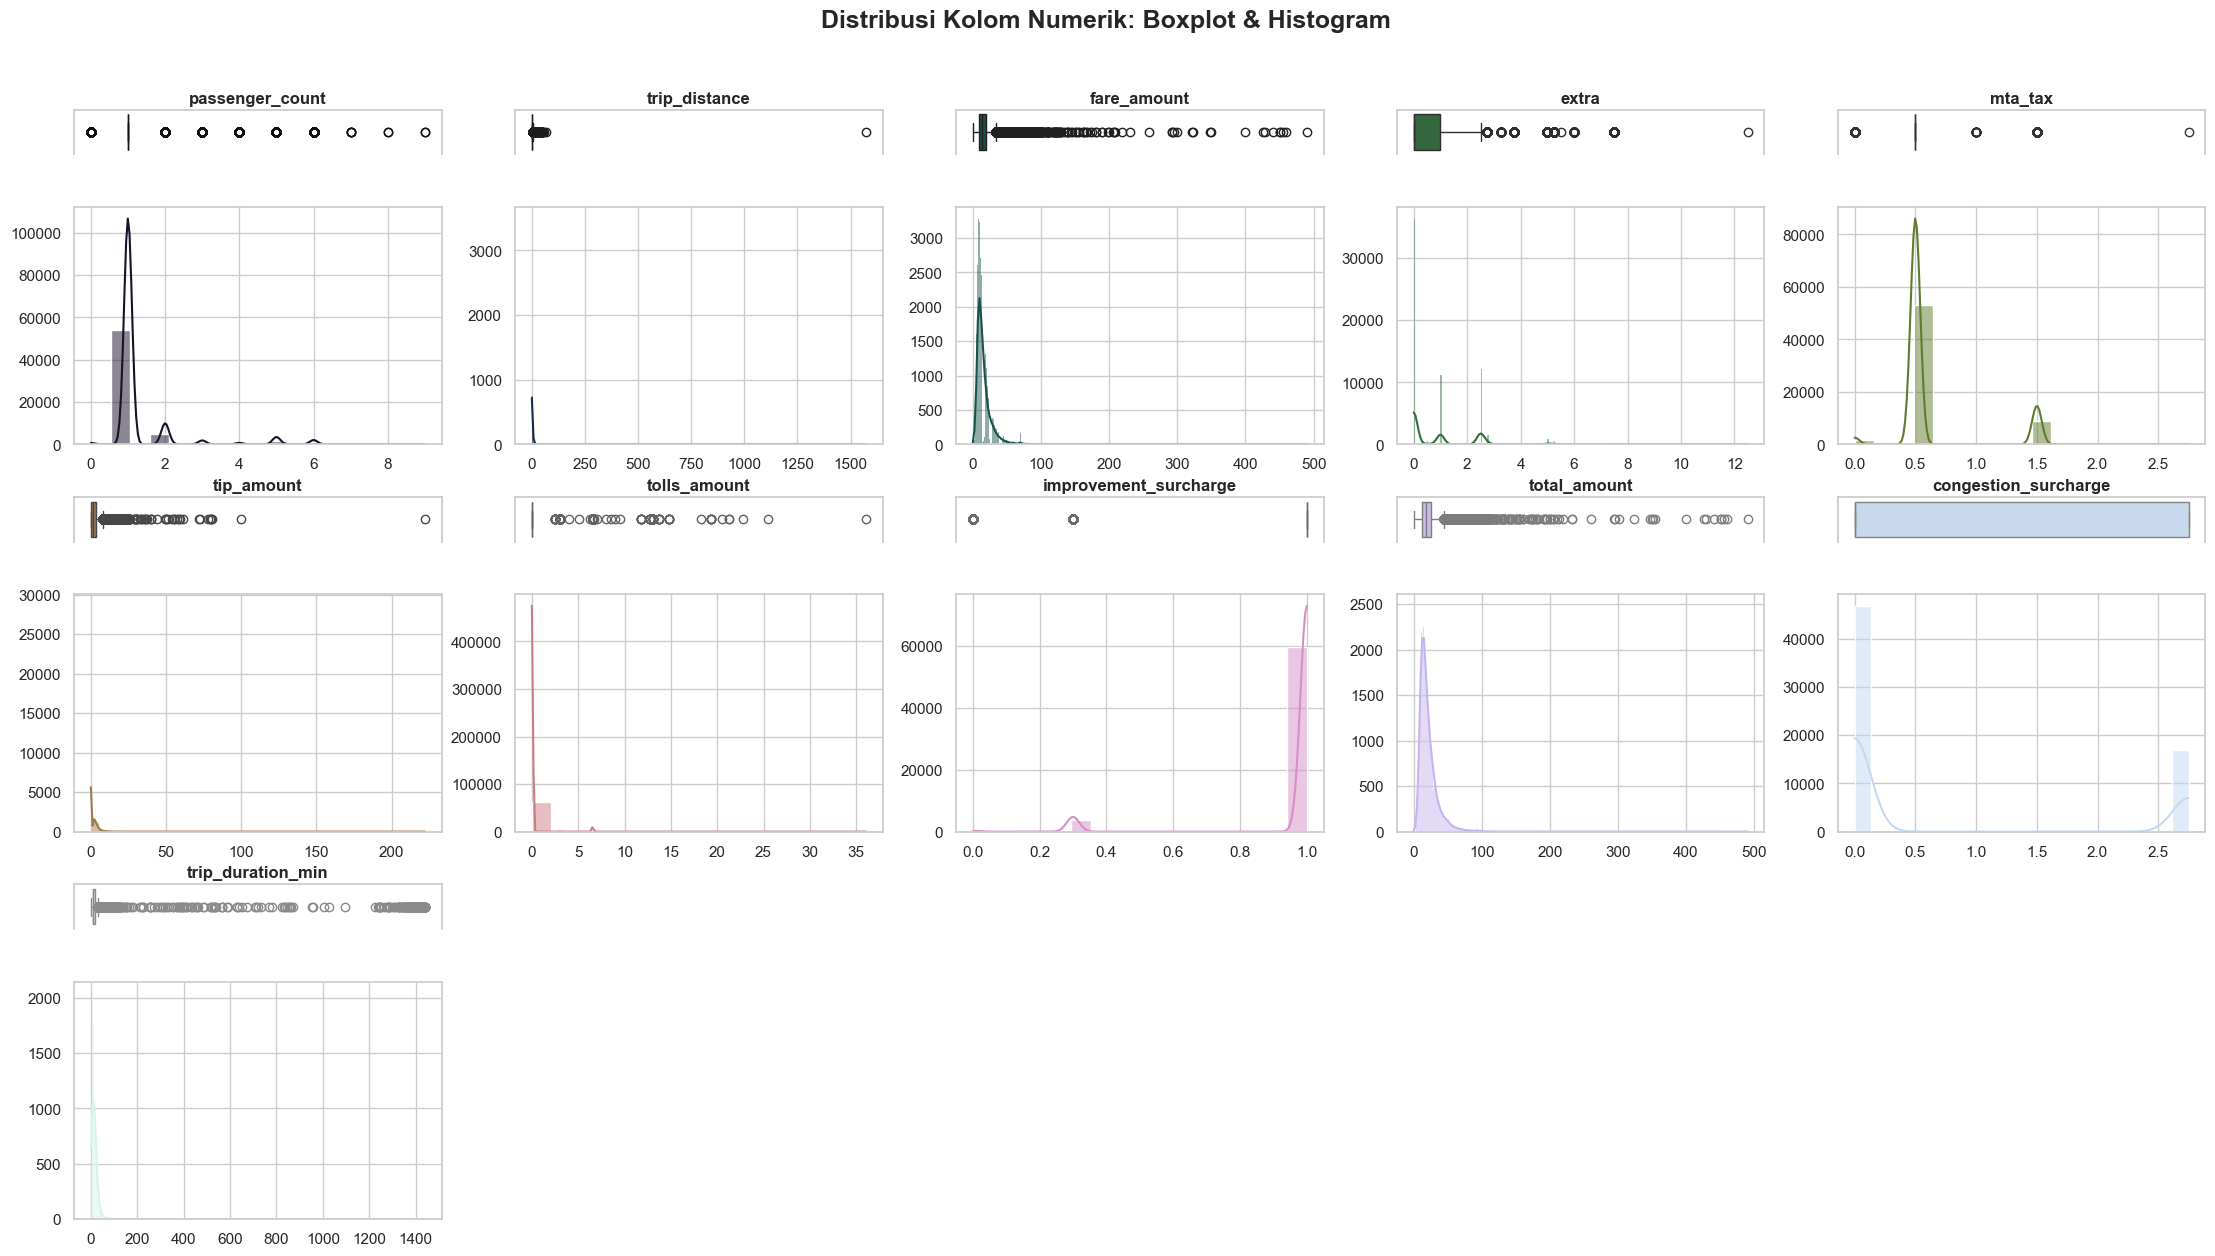

In [249]:
sns.set_theme(style='whitegrid')

palette = sns.color_palette("cubehelix", len(numerical))
color_map = dict(zip(numerical, palette))

n_cols = 5
n_rows = -(-len(numerical) // n_cols)

fig, axes = plt.subplots(
    nrows=n_rows * 2,
    ncols=n_cols,
    figsize=(n_cols * 5.5, n_rows * 4.8),
    gridspec_kw={'height_ratios': [0.15, 0.80] * n_rows, 'hspace': 0.375}
)

if n_rows == 1:
    axes = axes.reshape(2, -1)

for idx, col in enumerate(numerical):
    row = idx // n_cols
    col_pos = idx % n_cols

    ax_top = axes[row * 2, col_pos]
    ax_bot = axes[row * 2 + 1, col_pos]

    color = color_map[col]

    # Boxplot
    sns.boxplot(data=df, x=col, ax=ax_top, color=color)
    ax_top.set_title(col, fontsize=12, fontweight='bold', pad=5)
    ax_top.set_xlabel('')
    ax_top.set_xticks([])
    ax_top.set_ylabel('')
    ax_top.spines['bottom'].set_visible(False)

    # Histogram
    sns.histplot(data=df, x=col, ax=ax_bot, kde=True, color=color)
    ax_bot.set_xlabel('')
    ax_bot.set_ylabel('')

total_axes = n_rows * n_cols
for empty_idx in range(len(numerical), total_axes):
    fig.delaxes(axes[(empty_idx // n_cols) * 2, empty_idx % n_cols])
    fig.delaxes(axes[(empty_idx // n_cols) * 2 + 1, empty_idx % n_cols])

plt.suptitle("Distribusi Kolom Numerik: Boxplot & Histogram", fontsize=18, fontweight='bold', y=0.95)

plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

Dari boxplot dan histogram di atas, ditemukan beberapa keanehan seperti:

**1.** Jumlah `passenger_count` yang bernilai 0,

**2.** Outlier pada `tip_amount` yang jauh melampaui data lain,

**3.** Satu perjalanan outlier pada `trip_distance` yang jauh melampaui nilai lain, yaitu lebih dari 1500,

**4.** Ada 3 nilai unique pada `improvement_surcharge`,

**5.** Banyak nilai unique pada `mta_tax`,

**6.** Banyak durasi perjalanan yang melebihi 1000 menit pada `trip_duration_min`.

### `passenger_count`

In [250]:
df[(df['passenger_count'] == 0)].head()

,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,trip_type,congestion_surcharge,PU_Borough,PU_Zone,PUService_Zone,DO_Borough,DO_Zone,DOService_Zone,trip_duration_min,pickup_day,pickup_date,pickup_hour,VendorName,RatecodeName,payment_method,route
99,2023-01-01 01:27:36,2023-01-01 01:27:43,N,0.0,0.0,20.0,0.00,0.0,0.0,0.0,1.0,21.00,Dispatch,0.00,Bronx,Mott Haven/Port Morris,Boro Zone,Bronx,Mott Haven/Port Morris,Boro Zone,0.12,Sunday,2023-01-01,1,VeriFone Inc. (VTS),Negotiated Fare,Credit Card,Mott Haven/Port Morris → Mott Haven/Port Morris
254,2023-01-01 04:21:35,2023-01-01 04:30:00,N,0.0,1.3,8.0,0.50,1.5,2.8,4.0,1.0,16.80,Street Hail,0.00,Queens,Jackson Heights,Boro Zone,Queens,Jackson Heights,Boro Zone,8.42,Sunday,2023-01-01,4,Creative Mobile Technologies (CMT),Standard Rate,Credit Card,Jackson Heights → Jackson Heights
446,2023-01-01 11:42:13,2023-01-01 11:49:21,N,0.0,1.2,8.6,0.00,1.5,2.0,0.0,1.0,12.10,Street Hail,0.00,Queens,Woodside,Boro Zone,Queens,Woodside,Boro Zone,7.13,Sunday,2023-01-01,11,Creative Mobile Technologies (CMT),Standard Rate,Credit Card,Woodside → Woodside
486,2023-01-01 12:11:05,2023-01-01 12:20:45,N,0.0,3.4,16.3,0.00,1.5,1.0,0.0,1.0,18.80,Street Hail,0.00,Manhattan,Central Harlem North,Boro Zone,Manhattan,Inwood,Boro Zone,9.67,Sunday,2023-01-01,12,Creative Mobile Technologies (CMT),Standard Rate,Credit Card,Central Harlem North → Inwood
487,2023-01-01 12:56:11,2023-01-01 13:01:06,N,0.0,1.2,7.2,2.75,1.5,3.4,0.0,1.0,14.85,Street Hail,2.75,Manhattan,East Harlem South,Boro Zone,Manhattan,Upper East Side North,Yellow Zone,4.92,Sunday,2023-01-01,12,Creative Mobile Technologies (CMT),Standard Rate,Credit Card,East Harlem South → Upper East Side North


Ditemukan sejumlah 336 perjalanan yang mimiliki 0 penumpang, dan yang dihapus adalah pasangan `passenger_count` yang 0 dan `trip_dictance` 0 atau `passenger_count` dan `trip_duration_min` kurang dari 1 menit

In [251]:
penumpang_ghaib = df[(df['passenger_count'] == 0) & (df['trip_distance'] == 0) | ((df['passenger_count'] == 0) & (df['trip_duration_min'] < 1))]
len(penumpang_ghaib)

50

In [252]:
df = df[~df.index.isin(penumpang_ghaib.index)]

### `tip_amount`

In [253]:
df[df['tip_amount'] == df['tip_amount'].max()]

,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,trip_type,congestion_surcharge,PU_Borough,PU_Zone,PUService_Zone,DO_Borough,DO_Zone,DOService_Zone,trip_duration_min,pickup_day,pickup_date,pickup_hour,VendorName,RatecodeName,payment_method,route
50588,2023-01-25 18:24:30,2023-01-25 18:28:48,N,1.0,0.76,6.5,2.5,0.5,222.22,0.0,1.0,232.72,Street Hail,0.0,Queens,Steinway,Boro Zone,Queens,Steinway,Boro Zone,4.3,Wednesday,2023-01-25,18,VeriFone Inc. (VTS),Standard Rate,Credit Card,Steinway → Steinway


Outlier pada kolom `tip_amount` terlihat sangat tidak mungkin di mana penumpang yang hanya 1 orang memberi tip sebesar $222 untuk perjalanan yang hanya berjarak 0,76 mil dan lama perjalanan yang hanya 4 menit, sehingga baris ini akan dihapus

In [254]:
max_tip = df['tip_amount'].max()
df = df[df['tip_amount'] != max_tip]

### `trip_distance`

In [255]:
df[df['trip_distance'] == 0].sort_values('total_amount').head(5)

,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,trip_type,congestion_surcharge,PU_Borough,PU_Zone,PUService_Zone,DO_Borough,DO_Zone,DOService_Zone,trip_duration_min,pickup_day,pickup_date,pickup_hour,VendorName,RatecodeName,payment_method,route
47671,2023-01-24 14:34:58,2023-01-24 14:35:02,N,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Street Hail,0.0,Queens,Astoria,Boro Zone,Queens,Astoria,Boro Zone,0.07,Tuesday,2023-01-24,14,VeriFone Inc. (VTS),Standard Rate,Credit Card,Astoria → Astoria
29177,2023-01-15 13:51:19,2023-01-15 14:07:51,N,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Street Hail,0.0,Queens,East Elmhurst,Boro Zone,Queens,Astoria,Boro Zone,16.53,Sunday,2023-01-15,13,Creative Mobile Technologies (CMT),Standard Rate,Credit Card,East Elmhurst → Astoria
21687,2023-01-11 22:17:23,2023-01-11 22:17:56,N,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Street Hail,0.0,Queens,Queensbridge/Ravenswood,Boro Zone,Queens,Queensbridge/Ravenswood,Boro Zone,0.55,Wednesday,2023-01-11,22,VeriFone Inc. (VTS),Standard Rate,Credit Card,Queensbridge/Ravenswood → Queensbridge/Ravenswood
21686,2023-01-11 22:09:21,2023-01-11 22:09:50,N,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Street Hail,0.0,Queens,Queensbridge/Ravenswood,Boro Zone,Queens,Queensbridge/Ravenswood,Boro Zone,0.48,Wednesday,2023-01-11,22,VeriFone Inc. (VTS),Standard Rate,Credit Card,Queensbridge/Ravenswood → Queensbridge/Ravenswood
28612,2023-01-15 02:44:28,2023-01-15 02:44:45,N,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Dispatch,0.0,Queens,Flushing,Boro Zone,Queens,Flushing,Boro Zone,0.28,Sunday,2023-01-15,2,Creative Mobile Technologies (CMT),Negotiated Fare,No Charge,Flushing → Flushing


Ditemukan ada `trip_distance` yang bernilai 0, yang akan dibuang adalah pasangan `trip_distance` 0 yang `total_amount`nya juga 0 atau `trip_distance` 0 yang `trip_duration_min`nya kurang dari 1 menit (mengindikasikan perjalanan batal)

In [256]:
trip_dummy = df[((df['trip_distance'] == 0) & (df['total_amount'] == 0)) | ((df['trip_distance'] == 0) & (df['trip_duration_min'] < 1))]
len(trip_dummy)

1032

In [257]:
df = df[~df.index.isin(trip_dummy.index)]

In [258]:
df[df['trip_distance'] == df['trip_distance'].max()]

,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,trip_type,congestion_surcharge,PU_Borough,PU_Zone,PUService_Zone,DO_Borough,DO_Zone,DOService_Zone,trip_duration_min,pickup_day,pickup_date,pickup_hour,VendorName,RatecodeName,payment_method,route
33373,2023-01-17 18:40:38,2023-01-17 19:04:45,N,1.0,1571.97,29.97,0.0,0.0,3.04,6.55,1.0,43.31,Street Hail,2.75,Queens,Elmhurst,Boro Zone,Manhattan,Upper East Side North,Yellow Zone,24.12,Tuesday,2023-01-17,18,VeriFone Inc. (VTS),Negotiated Fare,Credit Card,Elmhurst → Upper East Side North


Terdapat 1 outlier pada `trip_distance` yang jauh melampaui nilai-nilai lainnya, kemungkinan karena kesalahan input. Jika dilihat dari kolom lainnya seperti lamanya perjalanan yang hanya 24 menit. Maka baris data outlier ini akan dihapus karena merusak data 

In [259]:
max_distance = df['trip_distance'].max()
df = df[df['trip_distance'] != max_distance]

### `improvement_surcharge`

In [260]:
df[df['improvement_surcharge'] == 0]['VendorName'].value_counts()

VendorName
Creative Mobile Technologies (CMT)    80
VeriFone Inc. (VTS)                   12
Name: count, dtype: int64

In [261]:
df[df['improvement_surcharge'] == 0.3]['VendorName'].value_counts()

VendorName
VeriFone Inc. (VTS)                   3773
Creative Mobile Technologies (CMT)       7
Name: count, dtype: int64

In [262]:
df[df['improvement_surcharge'] == 1]['VendorName'].value_counts()

VendorName
VeriFone Inc. (VTS)                   49825
Creative Mobile Technologies (CMT)     8918
Name: count, dtype: int64

Ditemukan ketidakkonsistenan pada nilai `improvement_surcharge`, yaitu nilai **0**, **0,3**, dan **1**. Jika mengacu pada dictionary kolom, seharusnya hanya ada satu nilai yaitu **0,3** yang diberlakukan setelah tahun 2015

In [263]:
df['improvement_surcharge'] = df['improvement_surcharge'].replace({0: 0.3, 1: 0.3})

### `mta_tax`

In [264]:
df['mta_tax'].value_counts()

mta_tax
0.5    52675
1.5     8901
0.0     1022
1.0       17
Name: count, dtype: int64

Tarif `mta_tax` seharusnya sebesar 0,5$ menurut dictionary kolom

In [265]:
df['mta_tax'] = 0.5

Dengan berubahnya `improvement_surcharge` dan `mta_tax`, maka kolom `total_amount` harus disesuaikan lagi

In [266]:
df['total_amount'] = (df['fare_amount'] + df['extra'] + df['mta_tax'] + df['tip_amount'] + df['tolls_amount'] + df['improvement_surcharge'] + df['congestion_surcharge'])

### `trip_duration_min`

In [267]:
df.sort_values('trip_duration_min',ascending=False).head()

,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,trip_type,congestion_surcharge,PU_Borough,PU_Zone,PUService_Zone,DO_Borough,DO_Zone,DOService_Zone,trip_duration_min,pickup_day,pickup_date,pickup_hour,VendorName,RatecodeName,payment_method,route
33850,2023-01-18 06:58:14,2023-01-19 06:57:10,N,1.0,1.09,7.9,0.0,0.5,0.00,0.0,0.3,8.70,Street Hail,0.00,Manhattan,East Harlem North,Boro Zone,Manhattan,Central Harlem,Boro Zone,1438.93,Wednesday,2023-01-18,6,VeriFone Inc. (VTS),Standard Rate,Credit Card,East Harlem North → Central Harlem
62120,2023-01-31 09:02:52,2023-02-01 09:01:47,N,1.0,0.87,7.9,0.0,0.5,0.00,0.0,0.3,8.70,Street Hail,0.00,Manhattan,Central Harlem,Boro Zone,Manhattan,Central Harlem North,Boro Zone,1438.92,Tuesday,2023-01-31,9,VeriFone Inc. (VTS),Standard Rate,Credit Card,Central Harlem → Central Harlem North
54199,2023-01-27 08:56:22,2023-01-28 08:55:17,N,1.0,1.89,11.4,0.0,0.5,3.91,0.0,0.3,18.86,Street Hail,2.75,Manhattan,Central Park,Yellow Zone,Manhattan,Upper West Side South,Yellow Zone,1438.92,Friday,2023-01-27,8,VeriFone Inc. (VTS),Standard Rate,Credit Card,Central Park → Upper West Side South
36253,2023-01-19 08:52:10,2023-01-20 08:51:03,N,1.0,0.04,23.0,0.0,0.5,7.20,0.0,0.3,31.00,Street Hail,0.00,Manhattan,East Harlem South,Boro Zone,Manhattan,East Harlem South,Boro Zone,1438.88,Thursday,2023-01-19,8,VeriFone Inc. (VTS),Newark,Credit Card,East Harlem South → East Harlem South
31477,2023-01-16 20:09:38,2023-01-17 20:08:24,N,1.0,1.63,10.7,1.0,0.5,0.66,0.0,0.3,13.16,Street Hail,0.00,Manhattan,Central Harlem North,Boro Zone,Manhattan,Central Park,Yellow Zone,1438.77,Monday,2023-01-16,20,VeriFone Inc. (VTS),Standard Rate,Credit Card,Central Harlem North → Central Park


Ditemukan data-data dengan `trip_duration_min` yang sangat besar

Yang akan dihapus adalah data yang memiliki `trip_duration_min` di atas 600 menit dan `trip_distance` di bawah 60 mil 

In [268]:
long_dur_trip = df[(df['trip_duration_min'] > 600) & (df['trip_distance'] < 60)]
len(long_dur_trip)

206

In [269]:
df = df[~df.index.isin(long_dur_trip.index)]

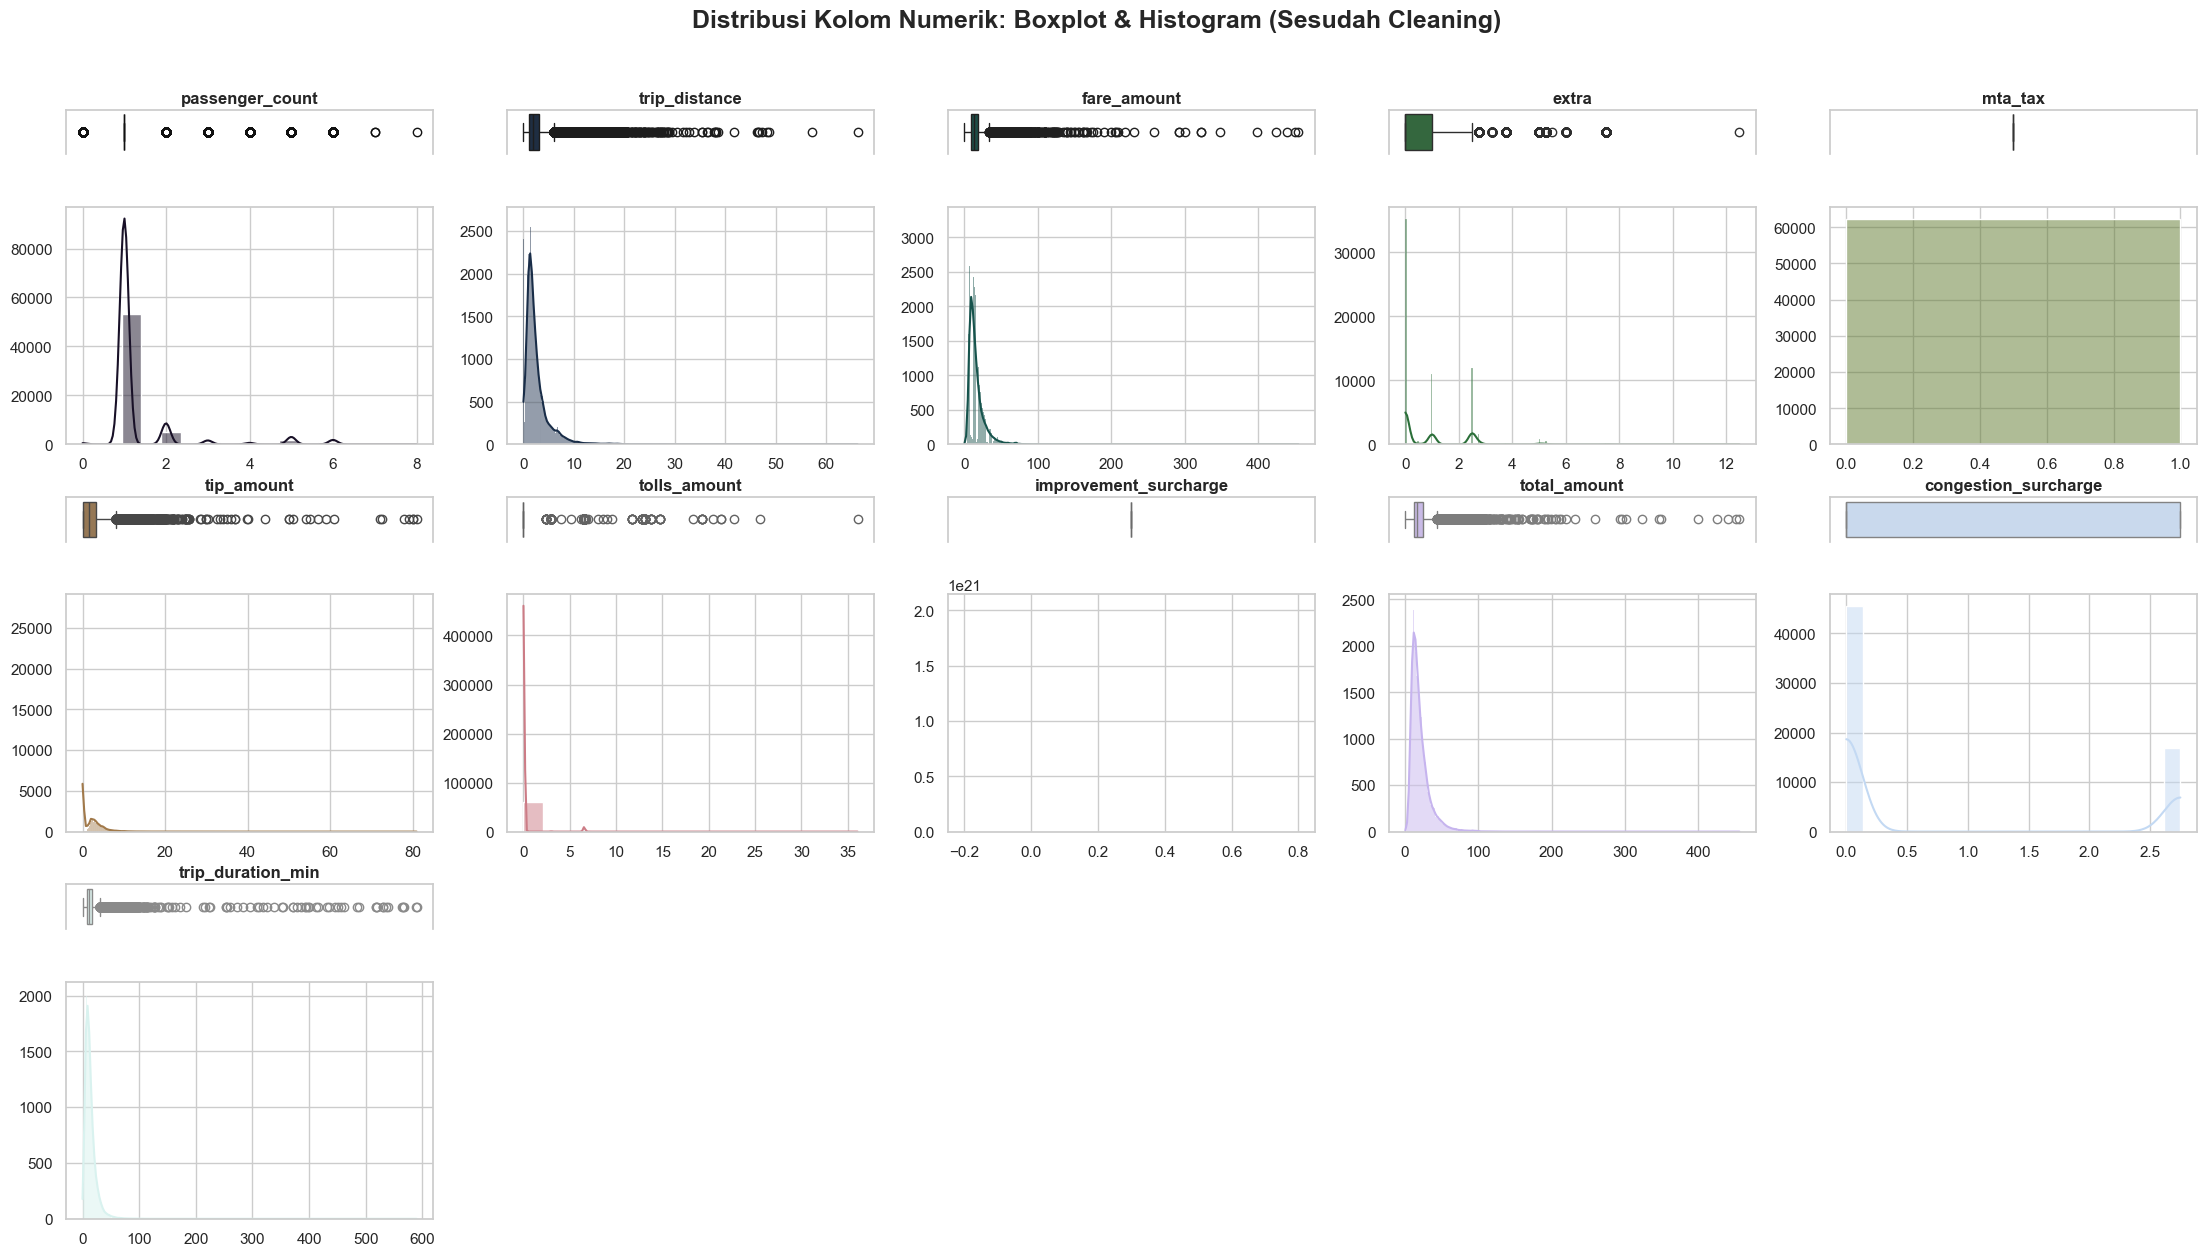

In [270]:
# pengecekan ulang
sns.set_theme(style='whitegrid')

palette = sns.color_palette("cubehelix", len(numerical))
color_map = dict(zip(numerical, palette))

n_cols = 5
n_rows = -(-len(numerical) // n_cols)

fig, axes = plt.subplots(
    nrows=n_rows * 2,
    ncols=n_cols,
    figsize=(n_cols * 5.5, n_rows * 4.8),
    gridspec_kw={'height_ratios': [0.15, 0.80] * n_rows, 'hspace': 0.375}
)

if n_rows == 1:
    axes = axes.reshape(2, -1)

for idx, col in enumerate(numerical):
    row = idx // n_cols
    col_pos = idx % n_cols

    ax_top = axes[row * 2, col_pos]
    ax_bot = axes[row * 2 + 1, col_pos]

    color = color_map[col]

    # Boxplot
    sns.boxplot(data=df, x=col, ax=ax_top, color=color)
    ax_top.set_title(col, fontsize=12, fontweight='bold', pad=5)
    ax_top.set_xlabel('')
    ax_top.set_xticks([])
    ax_top.set_ylabel('')
    ax_top.spines['bottom'].set_visible(False)

    # Histogram
    sns.histplot(data=df, x=col, ax=ax_bot, kde=True, color=color)
    ax_bot.set_xlabel('')
    ax_bot.set_ylabel('')

total_axes = n_rows * n_cols
for empty_idx in range(len(numerical), total_axes):
    fig.delaxes(axes[(empty_idx // n_cols) * 2, empty_idx % n_cols])
    fig.delaxes(axes[(empty_idx // n_cols) * 2 + 1, empty_idx % n_cols])

plt.suptitle("Distribusi Kolom Numerik: Boxplot & Histogram (Sesudah Cleaning)", fontsize=18, fontweight='bold', y=0.95)

plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

Data telah dibersihkan dan siap dianalisis.

In [271]:
# convert ke excel
df.to_excel("NYC_TLC_cleaned.xlsx", index=False)

# Analysis

## Statistika Deskriptif

### Numerik

In [272]:
df.describe()

,lpep_pickup_datetime,lpep_dropoff_datetime,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,trip_duration_min,pickup_hour
count,62409,62409,62409.000000,62409.000000,62409.000000,62409.000000,62409.0,62409.000000,62409.000000,6.240900e+04,62409.00000,62409.000000,62409.000000,62409.000000
mean,2023-01-16 22:49:12.655370240,2023-01-16 23:03:07.447195136,1.318303,2.599819,16.128137,0.895255,0.5,2.052294,0.146402,3.000000e-01,20.76336,0.741271,13.913206,13.926389
min,2023-01-01 00:01:31,2023-01-01 00:13:26,0.000000,0.000000,0.000000,0.000000,0.5,0.000000,0.000000,3.000000e-01,0.80000,0.000000,0.000000,0.000000
25%,2023-01-09 12:45:19,2023-01-09 12:56:15,1.000000,1.130000,9.300000,0.000000,0.5,0.000000,0.000000,3.000000e-01,12.20000,0.000000,7.280000,10.000000
50%,2023-01-17 09:07:54,2023-01-17 09:23:12,1.000000,1.820000,12.800000,0.000000,0.5,1.500000,0.000000,3.000000e-01,17.05000,0.000000,11.230000,15.000000
75%,2023-01-24 16:21:23,2023-01-24 16:36:36,1.000000,3.100000,19.100000,1.000000,0.5,3.240000,0.000000,3.000000e-01,25.10000,2.750000,16.970000,18.000000
max,2023-01-31 23:58:23,2023-02-01 00:31:14,8.000000,66.180000,455.000000,12.500000,0.5,80.880000,36.050000,3.000000e-01,455.80000,2.750000,589.730000,23.000000
std,NaN,NaN,0.982134,2.664952,12.478197,1.295017,0.0,2.804207,1.019970,1.110232e-16,14.41913,1.220195,15.007163,5.179885


Data numerik sudah bersih, dapat dilihat dari rentang nilai yang sudah dapat dikatakan wajar.

Mayoritas perjalanan dilakukan oleh satu penumpang dilihat dari median, berdurasi rata-rata sekitar 14 menit, dan jarak tempuh pendek (median 1,8 mil). Rata-rata biaya perjalanan adalah $20,76. Waktu penjemputan tersebar merata sepanjang hari, dengan puncak pada sore hari sekitar pukul 15.00. Secara keseluruhan, data ini mencerminkan layanan taksi yang lebih banyak digunakan untuk perjalanan jarak pendek oleh penumpang individu.

In [273]:
df.describe(include='object')

,store_and_fwd_flag,trip_type,PU_Borough,PU_Zone,PUService_Zone,DO_Borough,DO_Zone,DOService_Zone,pickup_day,pickup_date,VendorName,RatecodeName,payment_method,route
count,62409,62409,62409,62409,62409,62409,62409,62409,62409,62409,62409,62409,62409,62409
unique,2,2,6,219,4,7,247,5,7,31,2,5,5,5040
top,N,Street Hail,Manhattan,East Harlem North,Boro Zone,Manhattan,East Harlem South,Boro Zone,Tuesday,2023-01-26,VeriFone Inc. (VTS),Standard Rate,Credit Card,East Harlem North → East Harlem South
freq,62138,61504,37126,12833,58398,37060,3364,39974,10370,2454,53404,61185,39933,1963


Sebagian besar perjalanan taksi di Januari 2023 dilakukan di Manhattan dengan zona populer East Harlem North → East Harlem South, menggunakan vendor VeriFone Inc. (VTS), dengan metode pembayaran kartu kredit.

## Korelasi

### Korelasi Numerik

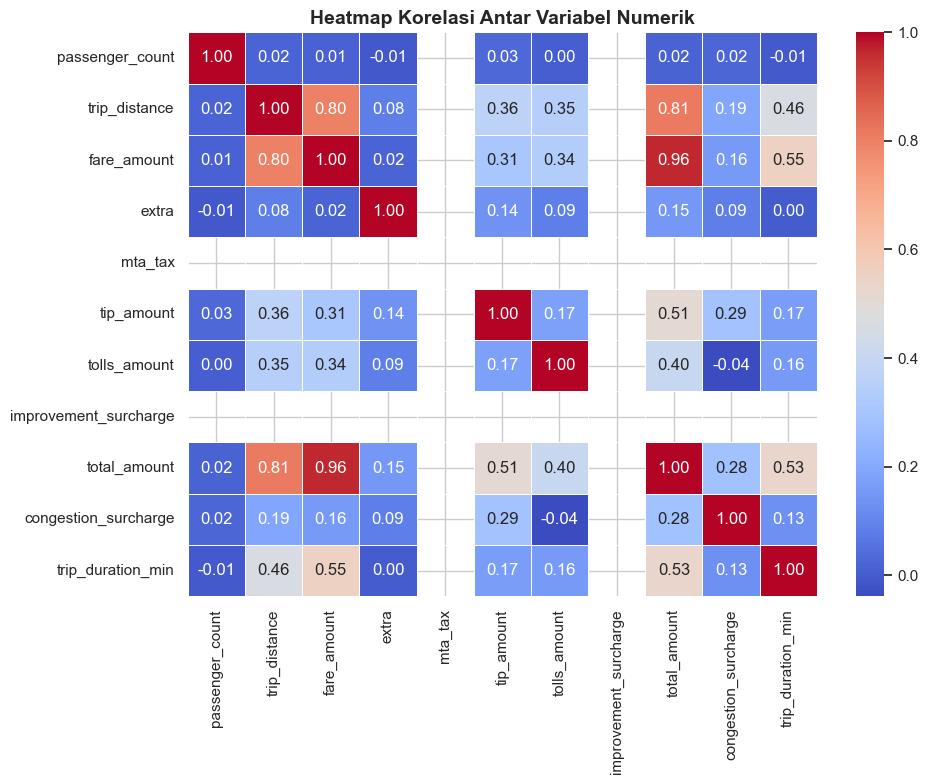

In [274]:
corr_matrix = df[numerical].corr(method='pearson')

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Heatmap Korelasi Antar Variabel Numerik", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

Ditemukan bahwa `trip_distance`, `fare_amount`, dan `total_amount` saling berkorelasi positif dan bersifat kausalitas, di mana semakin besar `trip_distance`, maka akan menghasilkan `fare_amount` yang juga besar, yang merupakan kontributor terbesar untuk `total_amount`. Maka untuk analisis selanjutnya akan berfokus ke `total_amount`.

### Korelasi Kategorik

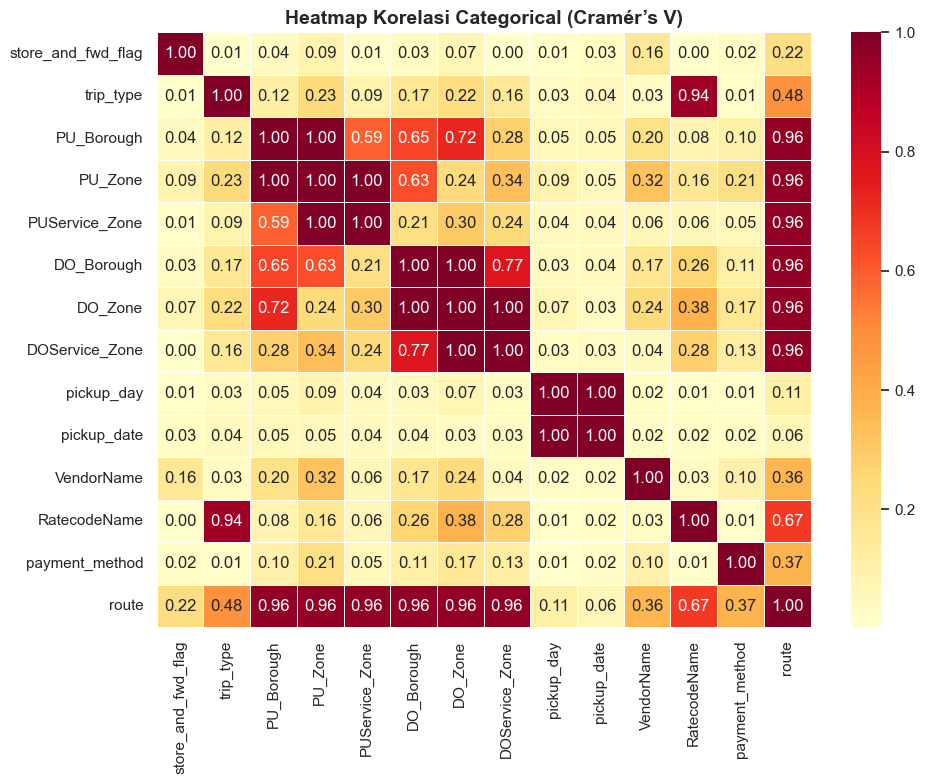

In [275]:
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2, p, dof, expected = chi2_contingency(confusion_matrix)
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))

cat_cat_corr = pd.DataFrame(index=categorical, columns=categorical)

for col1 in categorical:
    for col2 in categorical:
        if col1 == col2:
            cat_cat_corr.loc[col1, col2] = 1.0
        else:
            cat_cat_corr.loc[col1, col2] = cramers_v(df[col1], df[col2])

cat_cat_corr = cat_cat_corr.astype(float)

plt.figure(figsize=(10, 8))
sns.heatmap(cat_cat_corr, annot=True, fmt=".2f", cmap="YlOrRd", linewidths=0.5)
plt.title("Heatmap Korelasi Categorical (Cramér’s V)", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

Untuk kolom-kolom kategorik, yang berkorelasi didominasi oleh kolom-kolom yang berisi informasi lokasi. Kolom lain yang berkorelasi tinggi adalah `Ratecodename` dengan `trip_type`

## Berdasarkan Pickup Zone

### Jumlah Perjalanan

In [276]:
top_pu_count = df['PU_Zone'].value_counts().head(10).reset_index()
top_pu_count.columns = ['PU_Zone', 'pickup_count']

fig = px.bar(
    top_pu_count,
    x='pickup_count',
    y='PU_Zone',
    orientation='h',
    text='pickup_count',
    color='pickup_count',
    color_continuous_scale='cividis',
    title='Top 10 Pickup Zone berdasarkan Jumlah Perjalanan'
)
fig.update_traces(textposition='outside')
fig.update_layout(yaxis={'categoryorder':'total ascending'},
                  xaxis_title='Jumlah Pickup',
                  yaxis_title='Zona Pickup')
fig.show()

### Total Revenue

In [277]:
pu_revenue = df.groupby('PU_Zone')['total_amount'].sum().sort_values(ascending=False).head(10).reset_index()

fig = px.bar(
    pu_revenue,
    x='total_amount',
    y='PU_Zone',
    orientation='h',
    text='total_amount',
    color='total_amount',
    color_continuous_scale='thermal',
    title='Top 10 Pickup Zone berdasarkan Total Revenue'
)
fig.update_traces(texttemplate='$%{text:.2f}', textposition='outside')
fig.update_layout(yaxis={'categoryorder':'total ascending'},
                  xaxis_title='Total Revenue',
                  yaxis_title='Zona Pickup')
fig.show()

### Rata-Rata Revenue

In [278]:
pu_avg_revenue = df.groupby('PU_Zone')['total_amount'].mean().sort_values(ascending=False).head(10).reset_index()

fig = px.bar(
    pu_avg_revenue,
    x='total_amount',
    y='PU_Zone',
    orientation='h',
    title='Top 10 Pickup Zone Berdasarkan Rata-Rata Revenue',
    text='total_amount',
    color='total_amount',
    color_continuous_scale='viridis'
)
fig.update_traces(texttemplate='$%{text:.2f}', textposition='outside')
fig.update_layout(yaxis={'categoryorder': 'total ascending'},
                  xaxis_title='Rata-Rata Revenue',
                  yaxis_title='Zona Pickup')
fig.show()

### Rata-Rata Durasi Perjalanan

In [279]:
pu_duration = df.groupby('PU_Zone')['trip_duration_min'].mean().sort_values(ascending=False).head(10).reset_index()

fig = px.bar(
    pu_duration,
    x='trip_duration_min',
    y='PU_Zone',
    orientation='h',
    text='trip_duration_min',
    color='trip_duration_min',
    color_continuous_scale='Blues',
    title='Top 10 Pickup Zone dengan Durasi Rata-rata Tertinggi'
)
fig.update_traces(texttemplate='%{text:.1f} menit', textposition='outside')
fig.update_layout(yaxis={'categoryorder':'total ascending'},
                  xaxis_title='Rata-Rata Durasi (menit)',
                  yaxis_title='Zona Pickup')
fig.show()


Temuan-temuan dari visualisasi berdasarkan zone pickup sebagai berikut:

1. wilayah pemukiman padat seperti East Harlem North dan East Harlem South menjadi lokasi penjemputan paling populer

2. Wilayah pemukiman yang letaknya cukup jauh dari pusat kota seperti Glen Oaks, Bloomfield, South Beach dan wilayah bisnis seperti Midtown Center menyumbang rata-rata revenue tertinggi


## Berdasarkan Dropoff Zone

### Jumlah Perjalanan

In [280]:
top_do_count = df['DO_Zone'].value_counts().head(10).reset_index()
top_do_count.columns = ['DO_Zone', 'dropoff_count']

fig = px.bar(
    top_do_count,
    x='dropoff_count',
    y='DO_Zone',
    orientation='h',
    text='dropoff_count',
    color='dropoff_count',
    color_continuous_scale='cividis',
    title='Top 10 Dropoff Zone berdasarkan Jumlah Perjalanan'
)
fig.update_traces(textposition='outside')
fig.update_layout(yaxis={'categoryorder':'total ascending'},
                  xaxis_title='Jumlah Perjalanan',
                  yaxis_title='Zona Dropoff')
fig.show()

### Total Revenue

In [281]:
do_revenue = df.groupby('DO_Zone')['total_amount'].sum().sort_values(ascending=False).head(10).reset_index()

fig = px.bar(
    do_revenue,
    x='total_amount',
    y='DO_Zone',
    orientation='h',
    text='total_amount',
    color='total_amount',
    color_continuous_scale='thermal',
    title='Top 10 Dropoff Zone berdasarkan Total Revenue'
)
fig.update_traces(texttemplate='$%{text:.2f}', textposition='outside')
fig.update_layout(yaxis={'categoryorder':'total ascending'},
                  xaxis_title='Total Revenue',
                  yaxis_title='Zona Dropoff')
fig.show()


### Rata-Rata Revenue

In [282]:
do_avg_revenue = df.groupby('DO_Zone')['total_amount'].mean().sort_values(ascending=False).head(10).reset_index()

fig = px.bar(
    do_avg_revenue,
    x='total_amount',
    y='DO_Zone',
    orientation='h',
    title='Top 10 Dropoff Zone Berdasarkan Rata-Rata Revenue',
    text='total_amount',
    color='total_amount',
    color_continuous_scale='viridis'
)
fig.update_traces(texttemplate='$%{text:.2f}', textposition='outside')
fig.update_layout(yaxis={'categoryorder': 'total ascending'},
                  xaxis_title='Rata-Rata Revenue',
                  yaxis_title='Zona Dropoff')
fig.show()

### Rata-Rata Durasi Perjalanan

In [283]:
do_duration = df.groupby('DO_Zone')['trip_duration_min'].mean().sort_values(ascending=False).head(10).reset_index()

fig = px.bar(
    do_duration,
    x='trip_duration_min',
    y='DO_Zone',
    orientation='h',
    text='trip_duration_min',
    color='trip_duration_min',
    color_continuous_scale='Blues',
    title='Top 10 Dropoff Zone dengan Durasi Rata-rata Tertinggi'
)
fig.update_traces(texttemplate='%{text:.1f} menit', textposition='outside')
fig.update_layout(yaxis={'categoryorder':'total ascending'},
                  xaxis_title='Rata-Rata Durasi (menit)',
                  yaxis_title='Zona Dropoff')
fig.show()


Temuan pada zona dropoff:

1. Zona dropoff yang paling sibuk adalah zona-zona pemukiman padat, yaitu daerah Harlem dan Upper East Side

2. Zona dropoff yang memiliki rata-rata revenue tertinggi didominasi daerah bandara seperti Newark Airport dan JFK Airport, serta daerah wisata seperti Astoria Park, Breezy Point, dan Midland Beach. Zona-zona ini tidak muncul pada zona dropoff terpopuler, namun jika mempertimbangkan potensinya, zona-zona ini bisa dilabeli dengan zona premium

##  Berdasarkan Route

### Jumlah Perjalanan

In [284]:
top_routes = df['route'].value_counts().head(10).reset_index()
top_routes.columns = ['route', 'trip_count']

fig = px.bar(
    top_routes,
    x='trip_count',
    y='route',
    orientation='h',
    title='Top 10 Rute berdasarkan Jumlah Perjalanan',
    text='trip_count',
    color='trip_count',
    color_continuous_scale='cividis'
)
fig.update_traces(textposition='outside')
fig.update_layout(yaxis={'categoryorder':'total ascending'},
                  xaxis_title='Jumlah Perjalanan',
                  yaxis_title='Rute')
fig.show()

### Total Revenue

In [285]:
route_revenue = df.groupby('route')['total_amount'].sum().sort_values(ascending=False).head(10).reset_index()

fig = px.bar(
    route_revenue,
    x='total_amount',
    y='route',
    orientation='h',
    title='Top 10 Rute Berdasarkan Total Revenue',
    text='total_amount',
    color='total_amount',
    color_continuous_scale='thermal',
)
fig.update_traces(texttemplate='$%{text:.2f}', textposition='outside')
fig.update_layout(yaxis={'categoryorder':'total ascending'},
                  xaxis_title='Total Revenue',
                  yaxis_title='Rute')
fig.show()

### Rata-Rata Revenue

In [286]:
route_avg_revenue = df.groupby('route')['total_amount'].mean().sort_values(ascending=False).head(10).reset_index()

fig = px.bar(
    route_avg_revenue,
    x='total_amount',
    y='route',
    orientation='h',
    title='Top 10 Rute Berdasarkan Rata-rata Revenue per Perjalanan',
    text='total_amount',
    color='total_amount',
    color_continuous_scale='viridis'
)
fig.update_traces(texttemplate='$%{text:.2f}', textposition='outside')
fig.update_layout(yaxis={'categoryorder': 'total ascending'},
                  xaxis_title='Rata-rata Revenue',
                  yaxis_title='Rute')
fig.show()


In [287]:
route_summary = df.groupby(['PU_Zone', 'DO_Zone']).agg({
    'trip_distance': 'mean',
    'total_amount': 'sum',
    'route': 'count'
}).reset_index().rename(columns={'route': 'trip_count'})

fig = px.scatter(
    route_summary.sort_values('trip_count', ascending=False).head(50),
    x='PU_Zone',
    y='DO_Zone',
    size='trip_count',
    color='total_amount',
    hover_name='PU_Zone',
    title='50 Rute Terpopuler (PU vs DO Zone dengan Total Revenue dan Jumlah Perjalanan)',
    size_max=30,
    color_continuous_scale='cividis'
)
fig.update_layout(xaxis_tickangle=45,
                  xaxis_title='Zona Pickup',
                  yaxis_title='Zona Dropoff',
                  coloraxis_colorbar=dict(title='Total Revenue'))
fig.show()

### Rata-Rata Durasi Perjalanan

In [288]:
top_duration = df.groupby('route')['trip_duration_min'].mean().sort_values(ascending=False).head(10).reset_index()

fig = px.bar(
    top_duration,
    x='trip_duration_min',
    y='route',
    orientation='h',
    title='Top 10 Rute dengan Durasi Rata-Rata Tertinggi',
    text='trip_duration_min',
    color='trip_duration_min',
    color_continuous_scale='Blues'
)
fig.update_traces(texttemplate='%{text:.1f} min', textposition='outside')
fig.update_layout(yaxis={'categoryorder':'total ascending'},
                  xaxis_title='Rata-rata Durasi (menit)',
                  yaxis_title='Rute')
fig.show()

Temuan pada rute:

1. Sama seperti zona pickup dan dropoff, rute terpopuler adalah rute yang menghubungkan daerah-daerah pemukiman padat seperti Harlem dan Upper East Side

2. Rute yang menuju Astoria Park dan Newark Airport menjadi penyumbang rata-rata revenue tertinggi

3. Rute-rute dengan durasi perjalanan yang lama kemungkinan terjadi karena kemacetan, karena jika dilihat salah satu pasangan antara zona pickup dan dropoff merupakan zona yang ramai (Flushing, Queens Plaza, Astoria Park)

## Berdasarkan Hari

### Jumlah Perjalanan

In [289]:
weekday_trip = (
    df.groupby('pickup_day')
      .size()
      .reindex(['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'])
      .reset_index(name='trip_count')
)

fig = px.bar(
    weekday_trip,
    x='pickup_day',
    y='trip_count',
    title='Jumlah Perjalanan per Hari',
    text='trip_count',
    color='trip_count',
    color_continuous_scale='aggrnyl'
)
fig.update_traces(texttemplate='%{text}', textposition='outside')
fig.update_layout(
    xaxis_title='Hari',
    yaxis_title='Jumlah Perjalanan',
    xaxis_tickangle=0,
    height=600
)
fig.show()


### Total Revenue

In [290]:
weekday_revenue = (
    df.groupby('pickup_day')['total_amount']
      .sum()
      .reindex(['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'])
      .reset_index(name='total_revenue')
)

fig = px.bar(
    weekday_revenue,
    x='pickup_day',
    y='total_revenue',
    title='Total Revenue per Hari',
    text='total_revenue',
    color='total_revenue',
    color_continuous_scale='aggrnyl'
)
fig.update_traces(texttemplate='$%{text:.2f}', textposition='outside')
fig.update_layout(
    xaxis_title='Hari',
    yaxis_title='Total Revenue (USD)',
    xaxis_tickangle= 0,
    height=600
)
fig.show()

### Rata-Rata Revenue

In [291]:
avg_weekday_revenue = (
    df.groupby('pickup_day')['total_amount']
      .mean()
      .reindex(['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'])
      .reset_index(name='avg_revenue')
)

fig = px.bar(
    avg_weekday_revenue,
    x='pickup_day',
    y='avg_revenue',
    title='Rata‑rata Revenue per Hari',
    text='avg_revenue',
    color='avg_revenue',
    color_continuous_scale='aggrnyl'
)
fig.update_traces(texttemplate='$%{text:.2f}', textposition='outside')
fig.update_layout(
    xaxis_title='Hari',
    yaxis_title='Rata‑rata Revenue (USD)',
    xaxis_tickangle= -45,
    height=600
)
fig.show()

Tidak ada perbedaan signifikan pada rata-rata pendapatan, dengan hari Kamis sedikit lebih unggul dibandingkan dengan hari lainnya dengan menyentuh rata-rata $21. Namun, berdasarkan jumlah trip dan total revenue, hari dengan kinerja terbaik adalah hari Selasa dan yang terburuk justru saat weekend (Sabtu dan Minggu). Sehingga yang perlu dilakukan berkaitan dengan hari adalah mencoba untuk menaikkan jumlah perjalanan pada weekend.

## Berdasarkan Tanggal

### Jumlah Perjalanan

In [292]:
daily_trips = df.groupby(['pickup_date', 'pickup_day']).size().reset_index(name='trip_count')

fig = px.line(
    daily_trips,
    x='pickup_date',
    y='trip_count',
    title='Jumlah Perjalanan Harian (Januari 2023)',
    hover_data=['pickup_day'],
    markers=True,
    text='pickup_day'
)

fig.update_traces(
    textposition='top center',
    textfont=dict(size=8),
    marker=dict(size=8, color='purple'),
    line=dict(color='royalblue')
)

fig.update_layout(
    xaxis_title='Tanggal',
    yaxis_title='Jumlah Perjalanan',
    height=500
)
fig.show()

### Total Revenue

In [293]:
daily_revenue = (
    df.groupby(['pickup_date', 'pickup_day'])['total_amount']
      .sum()
      .reset_index(name='daily_revenue')
)

fig = px.line(
    daily_revenue,
    x='pickup_date',
    y='daily_revenue',
    title='Total Revenue Harian (Januari 2023)',
    hover_data=['pickup_day'],
    markers=True,
    text='pickup_day'
)

fig.update_traces(
    textposition='top center',
    textfont=dict(size=8),
    marker=dict(size=8, color='purple'),
    line=dict(color='royalblue')
)

fig.update_layout(
    xaxis_title='Tanggal',
    yaxis_title='Total revenue (USD)',
    hovermode='x unified',
    height=500
)
fig.show()

In [294]:
avg_daily_revenue = (
    df.groupby(['pickup_date', 'pickup_day'])['total_amount']
      .mean()
      .reset_index(name='daily_revenue')
)

fig = px.line(
    avg_daily_revenue,
    x='pickup_date',
    y='daily_revenue',
    title='Rata-Rata Revenue Harian (Januari 2023)',
    hover_data=['pickup_day'],
    markers=True,
    text='pickup_day'
)

fig.update_traces(
    textposition='top center',
    textfont=dict(size=8),
    marker=dict(size=8, color='purple'),
    line=dict(color='royalblue')
)

fig.update_layout(
    xaxis_title='Tanggal',
    yaxis_title='Rata-Rata revenue (USD)',
    hovermode='x unified',
    height=500,   
)
fig.show()

Tidak ada perbedaan signifikan antara line chart jumlah perjalanan dan total revenue periode Januari 2023, memastikan bahwa total revenue sangat dipengaruhi oleh jumlah trip yang dilakukan. Berikut temuan dari ketiga line chart di atas:

1. Pada 2 minggu awal, hari Jumat memiliki kinerja sangat baik dari segi kuantitas

2. Pada 2 minggu akhir, peak day bergeser ke hari Kamis, sedangkan hari Jumat mulai turun dari kuantitas

3. Grafik selalu turun saat weekend secara kuantitas

4. Tidak ada pola khusus pada grafik rata-rata revenue, namun yang bisa di-highlight adalah lonjakan rata-rata revenue pada saat 1 Januari (Tahun Baru) yang merupakan hari raya. Potensi pada hari raya seperti ini bisa dimanfaatkan pada hari-hari raya berikutnya.

## Berdasarkan Jam Penjemputan

### Jumlah Perjalanan

In [295]:
hourly_trips = df.groupby('pickup_hour').size().reset_index(name='trip_count')

hourly_trips['label'] = None
idx_max = hourly_trips['trip_count'].idxmax()
hourly_trips.loc[idx_max, 'label'] = hourly_trips.loc[idx_max, 'trip_count']

fig = px.line(
    hourly_trips,
    x='pickup_hour',
    y='trip_count',
    title='Jumlah Perjalanan per Jam',
    hover_data=['pickup_hour'],
    markers=True,
    text='label'
)

fig.update_traces(
    textposition='top center',
    textfont=dict(size=12),
    marker=dict(size=8, color='red'),
    line=dict(color='yellow')
)

fig.update_layout(
    xaxis_title='Jam (0-23)',
    yaxis_title='Jumlah Perjalanan',
    height=500,
    xaxis=dict(dtick=1),
    hovermode='x unified'
)
fig.show()

In [296]:
df_top_route = df[df['PU_Zone'] == 'East Harlem North']

hourly_trips = (
    df_top_route.groupby('pickup_hour')
    .size()
    .reset_index(name='trip_count')
)

hourly_trips['label'] = None
idx_max = hourly_trips['trip_count'].idxmax()
hourly_trips.loc[idx_max, 'label'] = hourly_trips.loc[idx_max, 'trip_count']

fig = px.line(
    hourly_trips,
    x='pickup_hour',
    y='trip_count',
    title='Jumlah Perjalanan per Jam untuk Zona Pickup Terpopuler (East Harlem North)',
    markers=True,
    text='label'
)

fig.update_traces(
    textposition='top center',
    textfont=dict(size=12),
    marker=dict(size=8, color='red'),
    line=dict(color='yellow')
)

fig.update_layout(
    xaxis_title='Jam (0–23)',
    yaxis_title='Jumlah Perjalanan',
    xaxis=dict(dtick=1),
    hovermode='x unified'
)

fig.show()

In [297]:
df_top_route = df[df['route'] == 'East Harlem North → East Harlem South']

hourly_trips = (
    df_top_route.groupby('pickup_hour')
    .size()
    .reset_index(name='trip_count')
)

hourly_trips['label'] = None
idx_max = hourly_trips['trip_count'].idxmax()
hourly_trips.loc[idx_max, 'label'] = hourly_trips.loc[idx_max, 'trip_count']

fig = px.line(
    hourly_trips,
    x='pickup_hour',
    y='trip_count',
    title='Jumlah Perjalanan per Jam untuk Rute Terpopuler (East Harlem North → East Harlem South)',
    markers=True,
    text='label'
)

fig.update_traces(
    textposition='top center',
    textfont=dict(size=12),
    marker=dict(size=8, color='red'),
    line=dict(color='yellow')
)

fig.update_layout(
    xaxis_title='Jam (0–23)',
    yaxis_title='Jumlah Perjalanan',
    xaxis=dict(dtick=1),
    hovermode='x unified'
)

fig.show()

### Total Revenue

In [298]:
hourly_revenue = (
    df.groupby('pickup_hour')['total_amount']
      .sum()
      .reset_index(name='hour_revenue')
)

hourly_revenue['label'] = None
idx_max = hourly_revenue['hour_revenue'].idxmax()
hourly_revenue.loc[idx_max, 'label'] = hourly_revenue.loc[idx_max, 'hour_revenue']

fig = px.line(
    hourly_revenue,
    x='pickup_hour',
    y='hour_revenue',
    title='Jumlah Revenue per Jam',
    hover_data=['pickup_hour'],
    markers=True,
    text='label'
)

fig.update_traces(
    textposition='top center',
    textfont=dict(size=12),
    marker=dict(size=8, color='red'),
    line=dict(color='yellow')
)

fig.update_layout(
    xaxis_title='Jam',
    yaxis_title='Jumlah Revenue',
    height=500,
    xaxis=dict(dtick=1),
    hovermode='x unified'
)
fig.show()

### Rata-Rata Revenue

In [299]:
avg_hourly_revenue = (
    df.groupby('pickup_hour')['total_amount']
      .mean()
      .reset_index(name='hour_revenue')
)

avg_hourly_revenue['label'] = None
idx_max = avg_hourly_revenue['hour_revenue'].idxmax()
avg_hourly_revenue.loc[idx_max, 'label'] = avg_hourly_revenue.loc[idx_max, 'hour_revenue']

fig = px.line(
    avg_hourly_revenue,
    x='pickup_hour',
    y='hour_revenue',
    title='Rata-Rata Revenue per Jam',
    hover_data=['pickup_hour'],
    markers=True,
    text='label'
)

fig.update_traces(
    textposition='top center',
    textfont=dict(size=12),
    marker=dict(size=8, color='red'),
    line=dict(color='yellow')
)

fig.update_layout(
    xaxis_title='Jam',
    yaxis_title='Rata-Rata Revenue',
    height=500,
    xaxis=dict(dtick=1),
    hovermode='x unified'
)
fig.show()

Berdasarkan jam, ditemukan hal-hal menarik berikut:

1. Peak hour secara kuantitas (jumlah perjalanan dan total revenue) adalah pada jam sore yaitu 15.00-19.00 (jam pulang kerja-makan malam) sehingga bisa diterapkan strategi penempatan yang lebih masif pada peak hour

2. Berbeda dari pola peak hour secara overall, peak hour pada zona penjemputan terpopuler yaitu `East Harlem North` dan rute terpopuler yaitu `East Harlem North → East Harlem South` adalah pagi hari, yang puncaknya di rentang jam 7.00-8.00 (jam berangkat kerja)

3. Rata-rata revenue cenderung tinggi saat jam dini hari, dengan peak hour berada di rentang jam 5.00-6.00, melampaui jam-jam lain. Namun secara kuantitas, rentang jam tersebut memang cukup rendah kinerjanya karena masih terlalu pagi untuk beraktivitas

## Berdasarkan Tipe Perjalanan

### Jumlah Perjalanan

In [300]:
count_trip_kind = df['trip_type'].value_counts().head(10).reset_index()
count_trip_kind.columns = ['trip_type', 'trip_count']


fig = px.bar(
    count_trip_kind,
    x='trip_type',
    y='trip_count',
    title='Total Revenue per Tipe Perjalanan',
    text='trip_count',
    color='trip_count',
    color_continuous_scale='speed'

)
fig.update_traces(textposition='outside')
fig.update_layout(
    xaxis_title='Tipe Perjalanan',
    yaxis_title='Total Revenue (USD)',
    xaxis_tickangle= 0,
    height=600
)
fig.show()

### Total Revenue

In [301]:
trip_kind = (
    df.groupby('trip_type')['total_amount']
      .sum()
      .reset_index(name='type')
)

fig = px.bar(
    trip_kind,
    x='trip_type',
    y='type',
    title='Total Revenue per Tipe Perjalanan',
    text='type',
    color='type',
    color_continuous_scale='speed'

)
fig.update_traces(texttemplate='$%{text:.2f}', textposition='outside')
fig.update_layout(
    xaxis_title='Tipe Perjalanan',
    yaxis_title='Total Revenue (USD)',
    xaxis_tickangle= 0,
    height=600
)
fig.show()

### Rata-Rata Revenue

In [302]:
avg_trip_kind = (
    df.groupby('trip_type')['total_amount']
      .mean()
      .reset_index(name='type')
)

fig = px.bar(
    avg_trip_kind,
    x='trip_type',
    y='type',
    title='Rata-Rata Revenue per Tipe Perjalanan',
    text='type',
    color='type',
    color_continuous_scale='speed'

)
fig.update_traces(texttemplate='$%{text:.2f}', textposition='outside')
fig.update_layout(
    xaxis_title='Tipe Perjalanan',
    yaxis_title='Rata-Rata Revenue (USD)',
    xaxis_tickangle= 0,
    height=600
)
fig.show()

Jumlah perjalanan dan revenue didomninasi oleh tipe perjalanan Street Hail (pemanggilan spontan), namun dapat dilihat dari rata-rata revenue bahwa tipe perjalanan Dispatch (booking) memiliki potensi besar yaitu sekitar 75% lebih besar daripada Street Hail. Potensi ini dapat dimanfaatkan dengan lebih mempopulerkan tipe Dispatch.

# Rekomendasi Bisnis

1. Optimalisasi armada di zona high demand dengan menempatkan minimal **10% armada tambahan** di zona pickup/dropoff dengan frekuensi tinggi seperti **East Harlem** pada **jam sibuk** di daerah tersebut (pukul 07.00 – 08.00 pagi). Armada dapat direalokasi dari zona dengan demand lebih rendah seperti Randalls Island dan Yorkville, yang secara geografis berdekatan namun tidak sepadat East Harlem. Tujuannya adalah untuk **mengurangi waktu tunggu penumpang hingga 5 menit** dan **meningkatkan pendapatan zona East Harlem North/South sebesar 2–5% dalam 1 bulan implementasi awal**.

2. Implementasi **zona premium** pada zona/rute dengan rata-rata revenue per perjalanan yang besar. Zona premium dapat diterapkan pada zona dropoff dengan **rata-rata revenue per trip > $30** dan **durasi perjalanan > 30 menit**, seperti **Astoria Park** dan **Newark Airport**. Zona premium akan dikenakan kenaikan **tarif sebesar 3–7%**, namun dengan **kompensasi reward** seperti voucher $1 atau snack/minuman gratis saat perjalanan. Strategi ini dapat diuji coba selama **2 minggu - 1 bulan** lalu **evaluasi tingkat retensi penumpang**.

3. Mengajak penumpang untuk lebih aktif melakukan perjalanan pada **jam dini hari** (pukul 00.00 - 05.00 pagi) dan **hari weekend** (Sabtu dan Minggu) dengan memberlalukan penawaran seperti **promo** sampai dengan 5% atau dengan memberi **reward** kecil-kecilan kepada penumpang seperti snack/minuman gratis. Promo berlaku untuk penumpang yang melakukan minimal **3 trip/minggu selama 2 minggu berturut-turut**. Strategi ini diharapkan dapat m**eningkatkan jumlah perjalanan sebesar 10%** di jam dini hari dan weekend ini **dalam waktu 1 bulan** setelah diberlakukan.

# Future Improvement

Mempertimbangkan potensi rata-rata revenue dari penumpang yang menggunakan cara **Dispatch** (membooking), Vendor disarankan untuk membuat sebuah **sistem booking online** yang dapat berupa aplikasi, dengan penerapan tarif yang lebih dinamis agar mempermudah pembookingan. Fitur-fitur yang dapat ditambahkan seperti **keterangan estimasi tarif, fitur penjadwalan, dan juga pembayaran digital**. Strategi ini dapat dicoba terlebih dahulu terhadap beberapa persen pengguna aktif atau untuk zona premium, lalu dievaluasi kinerjanya dari perbandingan waktu tunggu penumpang dan feedback penumpang. Pengembangan ini diharapkan dapat membuat **pengalokasian armada yang lebih tepat sasaran** sehingga tujuan utama untuk pengefisiensi perjalanan dapat tercapai.